In [3]:
%pip install humanfriendly

/home/lukas/school/tree-statistics/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [128]:
import os
os.environ['MEMORY_LIMIT'] = '16GB'

In [129]:
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join
from io import StringIO  
from datetime import timedelta

In [130]:
ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Sed',
    'lblint': 'Lbl-Int',
    'bib': 'Binary branch',
    'sedindex': 'Sed Index',
    'lblindex': 'Lbl-Int Index',
    'structuralindex': 'Structural Index',
}

datasets = ('dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')

In [131]:
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint',
    'bib': 'Bib'
}

In [132]:
BASEPATH = 'resources/results/'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for alg in ALGORITHMS.keys():
        join_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(join_times_path):
            print(alg, 'is not computed for', dataset, f'{join_times_path} skipping')
            continue
        df = pd.read_csv(join_times_path, names=["time"])
        
        candidate_eval_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(candidate_eval_times_path):
            print(alg, 'is not computed for', dataset, f'{candidate_eval_times_path} skipping')
            continue
        lb_df = pd.read_csv(candidate_eval_times_path, names=["query_filter_time_us"])
        
        with open(join(BASEPATH, dataset, str(threshold), f'{dataset}-{alg}-precision.txt')) as f:
            selectivity_line = f.readline()
            rest = f.read()
            
            if not selectivity_line.startswith('Mean selectivi'):
                rest = selectivity_line + rest

        # sel = selectivity_line.split(':')[1]
        # sel = float(sel.rstrip('%\n'))
        # print(sel)
        # seldf = pd.DataFrame.from_dict({'selectivity': [sel] })
        precision = pd.read_csv(StringIO(rest), delimiter=';')
        algorithm_times[alg] = [df, precision, lb_df]
    return algorithm_times

In [133]:
# tested_values= [('swissprot', 20), ('bolzano', 20), ('python', 30), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('DBLP', 6)]
tested_values= [('bolzano', 6), ('sentiment', 10), ('ptb', 15), ('treefam', 60), ('python', 15), ('dblp', 6), ('swissprot', 5)]

In [134]:
dataframes = dict()
for ds, t in tested_values:
    try:
        dataframes[ds] = load_dataset(ds, t)
    except Exception:
        print('Failed getting results from ', ds)

Failed getting results from  bolzano
Failed getting results from  sentiment
Failed getting results from  ptb
Failed getting results from  treefam
Failed getting results from  python
Failed getting results from  dblp
structural is not computed for swissprot resources/results/swissprot/5/swissprot-Structural-times-us.txt skipping
structural-variant is not computed for swissprot resources/results/swissprot/5/swissprot-StructuralVariant-times-us.txt skipping
sed is not computed for swissprot resources/results/swissprot/5/swissprot-Sed-times-us.txt skipping
lblint is not computed for swissprot resources/results/swissprot/5/swissprot-Lblint-times-us.txt skipping
bib is not computed for swissprot resources/results/swissprot/5/swissprot-Bib-times-us.txt skipping
Failed getting results from  swissprot


In [135]:
selectivities = [ (ds, float(dataframes[ds]['sed'][1]['Mean Selectivity'][0].rstrip('%') ), t) for ds, t in tested_values ]
selectivity_df = pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])
selectivity_df

KeyError: 'bolzano'

In [136]:
def load_stats(dataset: str):
    ds_path = join('./resources/statistics', dataset.lower())
    path = join(ds_path, 'collection.csv')
    df = pd.read_csv(path)
    depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(8, 'Mean node degree', [degrees['degree'].mean()])
    df.insert(8, 'Min node degree', [degrees['degree'].min()])
    df.insert(8, 'Max node degree', [degrees['degree'].max()])
    df.insert(8, 'Min tree height', [depths['root-leaf-distance'].min()])
    df.insert(8, 'Max tree height', [depths['root-leaf-distance'].max()])
    df.insert(8, 'Tree/Label ratio', df['tree_count'] / df['distinct_labels'])
    df.insert(8, 'Tree size/Label ratio', (df['avg_tree'] / df['distinct_labels']) * 100)
    df.insert(8, 'Mean tree height (root to leaf distance)', [depths['root-leaf-distance'].mean()])
    return (df, depths, degrees)

df = pd.DataFrame()
for i, (ds, _) in enumerate(tested_values):
    row = int(i >= 4)
    col = i % 4
    loaded, dep, deg = load_stats(ds)
    df = pd.concat([df, loaded])

pd.set_option('display.precision', 3)

df.reset_index()
df = df.rename(columns={
    'min_tree': 'Min tree size',
    'max_tree': 'Max tree size',
    'avg_tree': 'Average tree size',
    'tree_count': 'Trees',
    'avg_unique_labels_per_tree': 'Avg. unique labels for a tree',
    'avg_tree_distinct_labels': 'Avg. distinct labels in tree',
    'distinct_labels': 'No. of distinct labels',
    'trees': 'No. of trees in dataset',
})


# Collection statistics

- Average tree size => average node count in tree
- Trees => tree count in collection
- Avg. unique labels for a tree => Average collection wide unique labels (the average number of labels that are found only inside single tree)
- Avg. distinct labels in tree => Average distinct number of labels in each tree

In [137]:
display(df)

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels,Mean tree height (root to leaf distance),Tree size/Label ratio,Tree/Label ratio,Max tree height,Min tree height,Max node degree,Min node degree,Mean node degree,Unnamed: 7
0,Bolzano,2,2195,178.712,299,2.294,35.916,594,2.841,30.086,0.503,3,1,198,1,1.989,NaN
0,Sentiment,2,102,36.360,9645,1.040,19.900,19468,7.270,0.187,0.495,29,1,3,1,1.945,NaN
0,Ptb,3,711,71.595,3832,1.747,44.128,13094,6.874,0.547,0.293,29,2,33,1,1.972,NaN
0,Treefam,63,15065,2665.613,5000,223.343,592.227,1276006,16.709,0.209,0.004,54,2,8,1,1.999,NaN
0,Python,1,43270,948.242,49977,15.893,118.270,1479429,8.411,0.064,0.034,122,0,13974,0,1.998,NaN
0,Dblp,9,1703,26.073,150000,5.814,23.909,992866,2.018,0.003,0.151,5,1,430,1,1.923,NaN
0,Swissprot,2,20490,427.734,249831,12.388,170.313,3802604,3.127,0.011,0.066,6,1,2844,1,1.995,NaN


bolzano
sentiment
ptb
treefam
python
dblp
swissprot


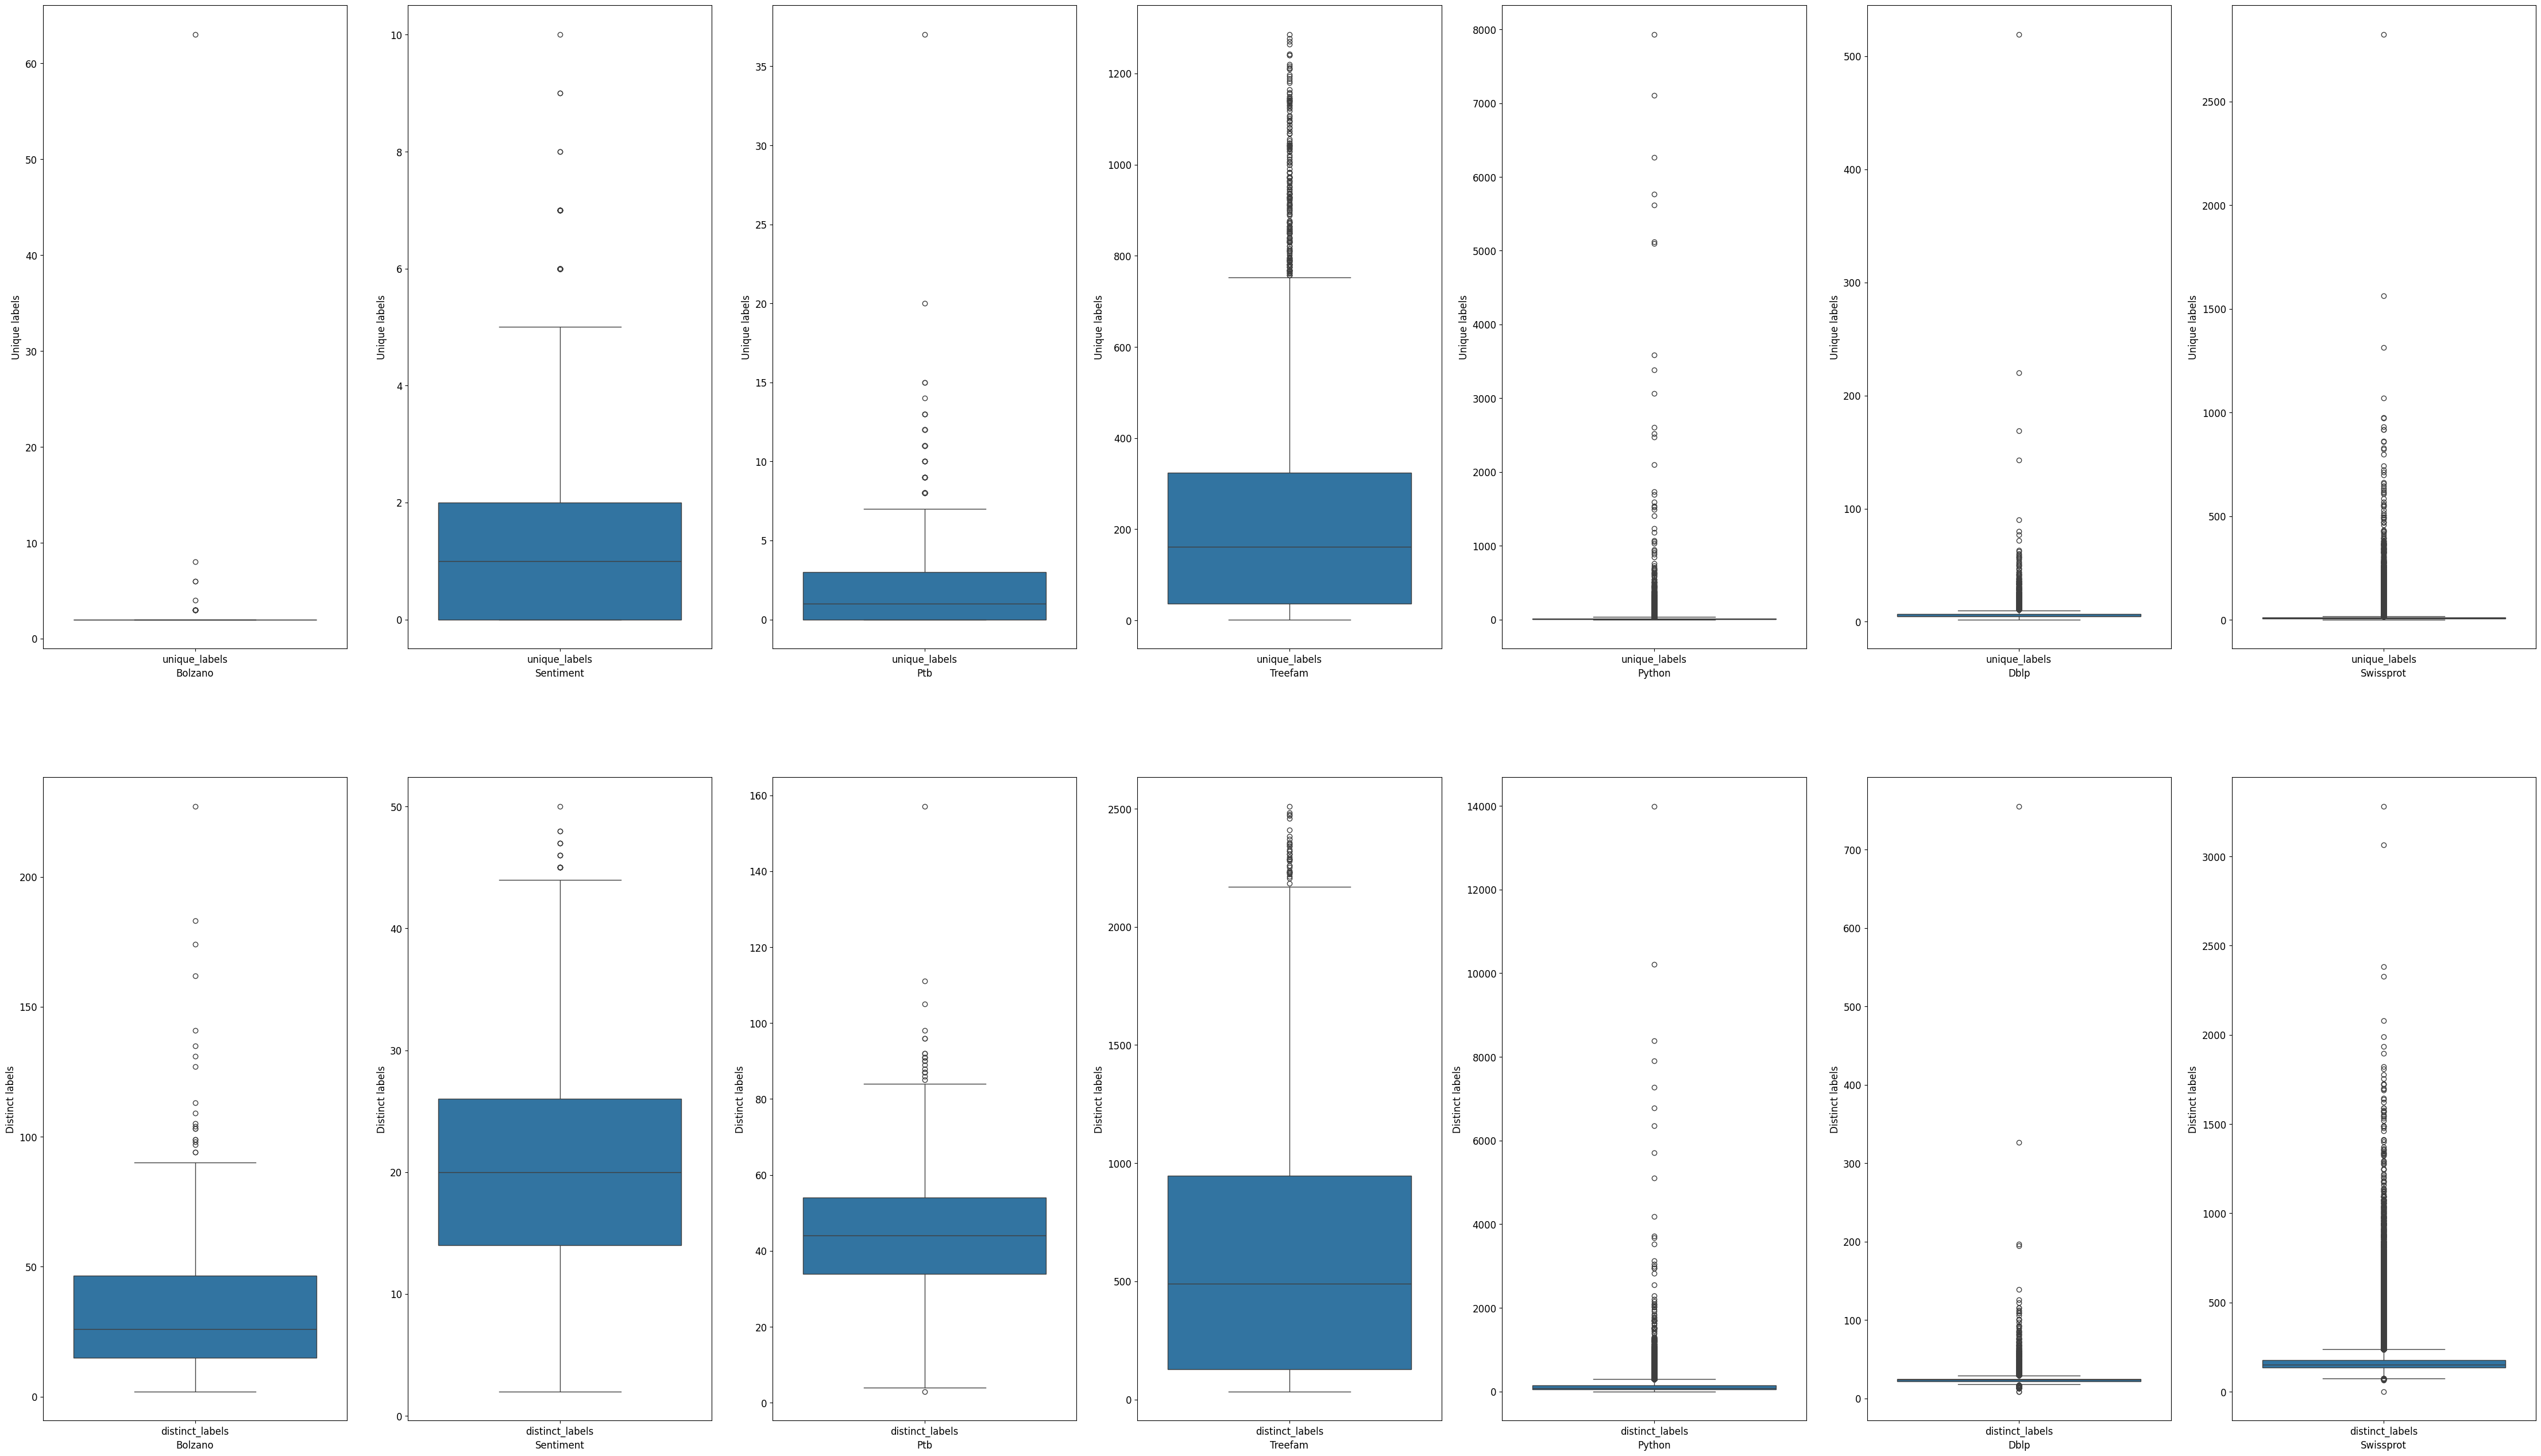

In [138]:
f, axes = plt.subplots(2, 7, figsize=(56, 32))

def load_stats(dataset: str, axis, i):
    ds_path = join('./resources/statistics', dataset.lower())
    # depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    # degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)
    distinct_labels = pd.read_csv(join(ds_path, 'distinct_labels.csv'), names=['distinct_labels'], header=None)
    unique_labels = pd.read_csv(join(ds_path, 'unique_labels.csv'), names=['unique_labels'], header=None)

    # sns.boxplot(depths, ax=axis[3][i])
    # axis[3][i].set(xlabel=dataset.capitalize(), ylabel='Depths')
    
    # sns.boxplot(degrees, ax=axis[2][i])
    # axis[2][i].set(xlabel=dataset.capitalize(), ylabel='Node degrees')
    
    sns.boxplot(distinct_labels, ax=axis[1][i])
    axis[1][i].set(xlabel=dataset.capitalize(), ylabel='Distinct labels')
    
    sns.boxplot(unique_labels, ax=axis[0][i])
    axis[0][i].set(xlabel=dataset.capitalize(), ylabel='Unique labels')
    
for i, (ds, _) in enumerate(tested_values):
    print(ds, flush=True)
    load_stats(ds, axes, i)

    
# f2, axes2 = plt.subplots(2, 4, figsize=(20, 12))
# f3, axes3 = plt.subplots(2, 4, figsize=(20, 12))
# f.suptitle('Root to leaf distance distrubution', fontsize=16)
# f2.suptitle('Node degree distribution', fontsize=16)
# f3.suptitle('Distinct labels distribution', fontsize=16)
# df = pd.DataFrame()
# for i, (ds, _) in enumerate(tested_values):
#     row = int(i >= 4)
#     col = i % 4
#     loaded, dep, deg, lbls = load_stats(ds)
#     hp = sns.histplot(data=dep, ax=axes[row][col], discrete=True)
#     hp.set(title=ds)
#     hp2 = sns.histplot(data=deg, ax=axes2[row][col], discrete=True)
#     hp2.set(title=ds)
#     hp3 = sns.histplot(data=lbls, ax=axes3[row][col], discrete=True)
#     hp3.set(title=ds)
#     df = pd.concat([df, loaded])

# pd.set_option('display.precision', 3)

# df.reset_index()
# df = df.rename(columns={
#     'mint': 'Min tree size',
#     'maxt': 'Max tree size',
#     'avgt': 'Average tree size',
#     'distinct_labels': 'No. of distinct labels',
#     'trees': 'No. of trees in dataset',
# })
# display(df)

In [139]:
def load_verification_times(dataset: str, threshold: int):
    runtime_df, absolute_df, lb_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    empty = True
    for lb_method in ALGORITHMS.keys():
        # print(lb_method)
        apted_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-apted-verification-times-ns.csv')
        topdiff_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-topdiff-verification-times-ns.csv')
    
        apted_df = pd.read_csv(apted_times, skiprows=2, names=["apted-verification-nanos"])
        topdiff_df = pd.read_csv(topdiff_times, skiprows=2, names=["topdiff-verification-nanos"])
        df = apted_df.join(topdiff_df).join(dataframes[dataset][lb_method][2])
        df['query_filter_time_nanos'] = df['query_filter_time_us'] * 1000
        
        df['lb_method'] = ALGORITHMS[lb_method]

        # runtime is in MS
        rtdf = pd.DataFrame.from_records([
            (
                (df['apted-verification-nanos'].sum() / 1000 / 1000),
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000),
                df['query_filter_time_us'].sum() / 1000,
                (df['apted-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                lb_method
            )
        ] , columns=['apted-candidates', 'topdiff-candidates', 'lb-runtime', 'apted-runtime', 'topdiff-runtime', 'lb_method'])
        
        v_vars=['apted-runtime', 'topdiff-runtime']
        
        # total_runtime = df.melt(
        #     value_vars=v_vars, id_vars=['lb_method'], var_name='verification-method', value_name='runtime'
        # )
        
        melted_absolute = df.melt(
            value_vars=['apted-verification-nanos', 'topdiff-verification-nanos'], id_vars=['lb_method'], var_name='verification-method', value_name='nanos'
        )

        melted_lb = df.melt(value_vars=['query_filter_time_us'], id_vars=['lb_method'], value_name='lb_time')
        
        if empty:
            runtime_df = rtdf
            absolute_df = melted_absolute
            lb_df = melted_lb
            empty = False
        else:
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            runtime_df = pd.concat([runtime_df, rtdf], ignore_index=True)
            absolute_df = pd.concat([absolute_df, melted_absolute], ignore_index=True)
            lb_df = pd.concat([lb_df, melted_lb], ignore_index=True)
        # df['lb-apted-perc'] = 100 - df['apted-perc']
        # df['lb-topdiff-perc'] =  100 - df['topdiff-perc'] 
    
    return runtime_df, absolute_df, lb_df
    ...

In [140]:
runtime, melted_absolute, lb_df = load_verification_times('bolzano', 6)

KeyError: 'bolzano'

In [ ]:
humanfriendly.format_timespan(timedelta(milliseconds=3810159.25010))

# Verification time (TED time) % of complete LB + verification time

The lower the verification time %, the faster the LB method was in comparison to verification by using
either exact TED (APTED) or using bounded-TED (topdiff)

In [ ]:
verification_times = []
for i, (ds, t) in enumerate(tested_values):
    print('Loading ', ds, ', t =', t, i)
    verification_times.append(load_verification_times(ds, t))

In [35]:
new_labels = ["Structural", "Splitted structural", "String LB", "Label intersection", "Binary branch"]
# new_labels = ["Structural", "Splitted structural", "String LB", "Label intersection"]

In [36]:
runtime, melted_absolute, lb_df = verification_times[-1]

display(runtime)

rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')
grouped = rtmt.groupby(['lb_method', 'verification method']).sum()
upper_bound = grouped.loc[('structural-variant', 'apted-runtime')]['runtime'] + grouped.loc[('sed', 'apted-runtime')]['runtime']
grouped
# upper_bound = grouped['structural-variant'] + grouped['


IndexError: list index out of range

Loading  swissprot , t = 5 0


IndexError: list index out of range

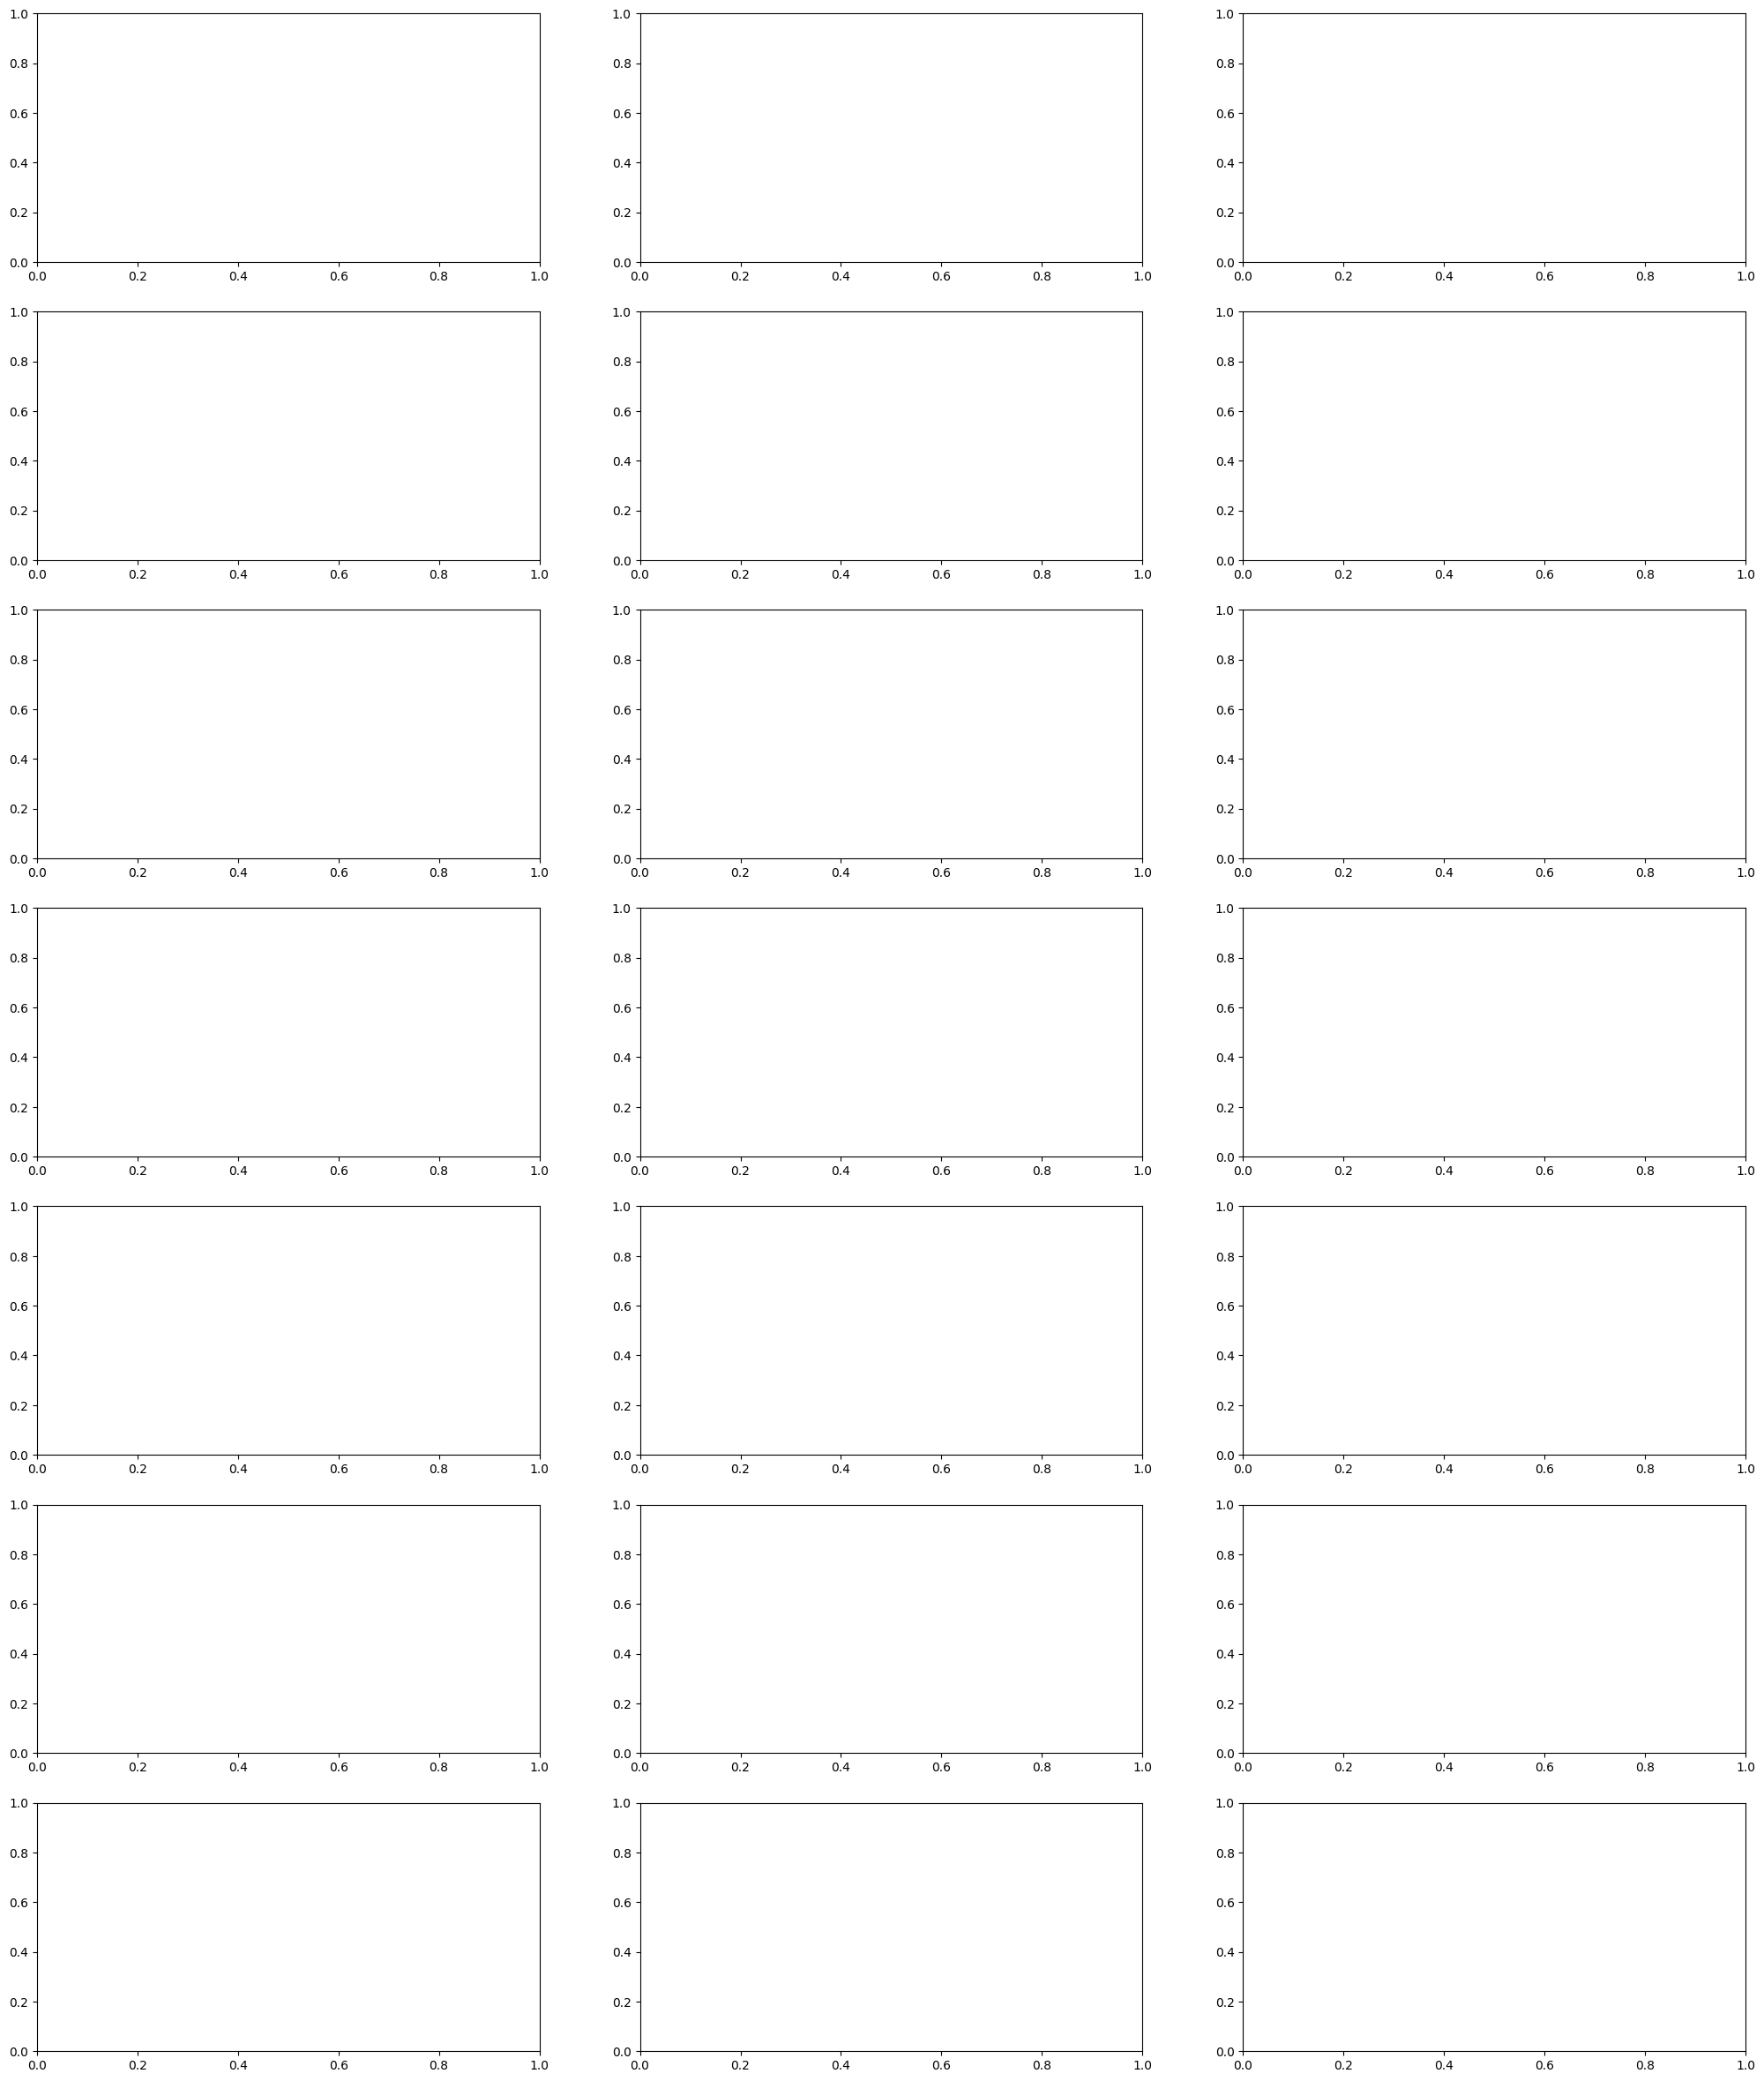

In [37]:
len_tested = len(tested_values)
fig, axes = plt.subplots(len_tested, 3, figsize=(25, 30))
# http://localhost:8888/lab/tree/TED-viz.ipynb#Verification-time-(TED-time)-%-of-complete-LB-+-verification-time
for i, (ds, t) in enumerate(tested_values[-1:]):
    print('Loading ', ds, ', t =', t, i)
    ###### Filter runtime #########
    runtime, melted_absolute, lb_df = verification_times[i]
    ofix, oax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=axes[i, 0])
    
    filter_boxplot = sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=oax)
    oax.set_title('LB filter time')
    oax.set_ylabel('Microseconds')
    oax.set_xlabel('LB filter')
    ofix.savefig(f"resources/plots/{ds}-filter-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)
    ofix, oax = plt.subplots(figsize=(10, 6))


    ###### Verification times #########
    # axes[i, 0].set_title('LB comp time in nanoseconds')
    sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=axes[i, 1])
    verif_plot = sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=oax)
    sns.move_legend(oax, 'best', title='LB method', labels=new_labels)
    axes[i, 1].set_title('TED verification in nanoseconds')
    oax.set_title('TED verification in nanoseconds')
    oax.set_ylabel('Nanoseconds')
    oax.set_xlabel('Verification method')
    # sns.move_legend(axes[i, 1], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(oax, "upper left", bbox_to_anchor=(1, 1))
    
    ofix.savefig(f"resources/plots/{ds}-verification-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)

    ###### Overall runtime #########
    ofix, oax = plt.subplots(figsize=(10, 6))
    rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')

    grouped = rtmt.groupby(['lb_method', 'verification method']).sum()
    upper_bound = grouped.loc[('structural-variant', 'apted-runtime')]['runtime'] + grouped.loc[('sed', 'apted-runtime')]['runtime']
    
    sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=axes[i, 2])
    axes[i, 2].set_ylim(0, upper_bound)
    runtime_fig = sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=oax)
    sns.move_legend(axes[i, 2], "upper left", bbox_to_anchor=(1, 1))
    axes[i, 2].set_title('Total runtime')
    axes[i, 2].set_ylabel('Total runtime with verification')

    # axes[i, 2].bar_label(axes[i, 2].containers[-1], label_type='center', rotation=90, color='white')

    # sns.move_legend(oax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(oax, 'best', title='LB method', labels=new_labels)
    oax.set_ylim(0, upper_bound)
    oax.set_title('Total runtime')
    oax.set_ylabel('Nanoseconds')
    oax.set_xlabel('Verification method')

    lbl_type = 'center' if ds not in ('python', ) else 'edge'
    oax.bar_label(oax.containers[-1], label_type=lbl_type, rotation=90, color='black')
    if ds == 'treefam':
        oax.bar_label(oax.containers[-2], label_type='center', rotation=90, color='black')
    
    ofix.savefig(f"resources/plots/{ds}-overall-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)

for ax, (ds, _) in zip(axes[:, 0], tested_values[-1:]):
    ax.set_ylabel(ds, size='large')

plt.tight_layout()
plt.show()

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(32, 11))
f.suptitle('Single tree to dataset search time in Microseconds, SPLIT=4')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)

    df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = ALGORITHMS[alg]
        df = pd.concat([df, times])
    bp = sns.boxplot(data=df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

In [ ]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds.capitalize()
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
# sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(14, 8))
hp = sns.heatmap(pivoted, fmt='.1%', annot=True)
plt.yticks(rotation=0) 
plt.ylabel("Dataset", rotation=0, fontsize="large")
hp.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = True, labeltop=True)
fig.savefig("resources/plots/precision-heatmap.svg", format='svg')
hp.set(title='Precision heatmap, SPLIT=4')


In [38]:
summary = dataframes[ds][alg][1].copy()
summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
summary

KeyError: 'swissprot'

In [39]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds.capitalize()
        summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
        summary = summary.astype({'Mean Selectivity': 'float64'})
        summary['Mean Selectivity'] = summary['Mean Selectivity'] / 100
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Mean Selectivity").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True, fmt='.2%')
hp.set(title='Selectivity heatmap, SPLIT=4')

KeyError: 'bolzano'

In [40]:
dataframes = dict()
tested_values = [('sentiment', 5), ('sentiment', 15), ('sentiment', 20), ('sentiment', 10)]
dataframes['sentiment'] = dict()
for ds, t in tested_values:
    dataframes[ds][t] = load_dataset(ds, t)

structural is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Structural-times-us.txt skipping
structural-variant is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-StructuralVariant-times-us.txt skipping
sed is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Sed-times-us.txt skipping
lblint is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Lblint-times-us.txt skipping
bib is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Bib-times-us.txt skipping


KeyError: 'sedindex'

In [41]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds][x].keys():
        summary = dataframes[ds][x][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Threshold'] = x
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Algorithm", columns="Threshold", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Sentiment Precision heatmap, SPLIT=4')

KeyError: 5

In [42]:
selectivities = [('sentiment', 0.0746, 5), ('sentiment', 0.859, 10), ('sentiment', 3.04574, 15), ('sentiment', 8.496, 20)]
pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])

,Dataset,Mean query selectivity %,Threshold
0,sentiment,0.075,5
1,sentiment,0.859,10
2,sentiment,3.046,15
3,sentiment,8.496,20


In [43]:
df = pd.read_csv('./python-Structural-times-us.txt', header=None, names=["LB time"])

FileNotFoundError: [Errno 2] No such file or directory: './python-Structural-times-us.txt'

In [44]:
df['LB time'].sum() / 1000 / 1000

KeyError: 'LB time'

In [45]:
df = pd.read_csv('./resources/results/python/15/python-Structural-times-us.txt', header=None, names=["LB time"])

In [46]:
df['LB time'].sum() / 1000 / 1000

186.34054999999998

# TED Search Start - precision

In [185]:
from os.path import join

In [192]:
datasets = [ds for ds, _ in tested_values if ds not in ['bolzano']]
datasets

['sentiment', 'ptb', 'treefam', 'python', 'dblp', 'swissprot']

In [170]:
ALGORITHMS

{'structural': 'Structural',
 'structural-variant': 'Splitted Structural',
 'sed': 'Sed',
 'lblint': 'Lbl-Int',
 'bib': 'Binary branch',
 'sedindex': 'Sed Index',
 'lblindex': 'Lbl-Int Index',
 'structuralindex': 'Structural Index'}

In [193]:
df = pd.DataFrame()
cdf = pd.DataFrame()
for ds in datasets:
    times_path = join('resources/puser-results', ds, 'times.txt')
    t = pd.read_csv(times_path, delimiter=';')
    t = t.rename(columns=ALGORITHMS)
    df = pd.concat([df, t.head(1)])
    
    cdf = pd.concat([cdf, t.iloc[[1]]])
df = df.set_index('dataset')
cdf = cdf.set_index('dataset')
# display(df)
display(df.transpose())
display(cdf)

dataset,sentiment,ptb,treefam,python,dblp,swissprot
Lbl-Int Index,6,12,47,35,335,103
Lbl-Int,10,74,29,418,19659,12090
Sed Index,12,59,271,300,2110,1290
Sed,41,179,223,238,18244,17751
Structural Index,18,25,151,89,775,648
Structural,15,184,67,1018,21306,46511


,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural
dataset,,,,,,
sentiment,222,222,135,135,153,153
ptb,372,372,245,245,322,322
treefam,14075,14075,8055,8055,8268,8268
python,72288,72288,72288,72288,72288,72288
dblp,136180,136180,70641,70641,71750,71750
swissprot,6784,6784,4666,4666,6652,6652


In [88]:
['ahoj'] * 3

['ahoj', 'ahoj', 'ahoj']

In [194]:
# precision dataframe
pdf = pd.DataFrame()
vdf = pd.DataFrame()
for ds in datasets:
    temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
    tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
    times_ = []
    methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
    for mtd in ('Lblint', 'Sed', 'Structural'):
        k = mtd.replace('Lblint', 'Lbl-Int')
        candidate_count = cdf[k][ds]
        verification_path = join('resources/puser-results', ds, f'{mtd}-verification.txt')
        with open(verification_path) as f:
            lines = f.read().split('\n')
        times = pd.Series([float(t) for t in lines[:candidate_count]])
        correct_results = lines[candidate_count:]
        precision =  (len(lines) - 1 - candidate_count) / candidate_count
        temp_df[mtd] = precision
        temp_df

        total_verification_time_ms = times.div(1000_000).sum()
        # twice for index version
        times_.extend([total_verification_time_ms, total_verification_time_ms])
        # print(ds, mtd, precision)
    # temp_df = pd.DataFrame()
    pdf = pd.concat([pdf, temp_df])
    vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])

pdf = pdf.set_index("dataset")
vdf.sort_values(['Method', 'Dataset'], inplace=True)
# display(pdf)
# display(vdf)


[Text(0.5, 1.0, 'Query search precision')]

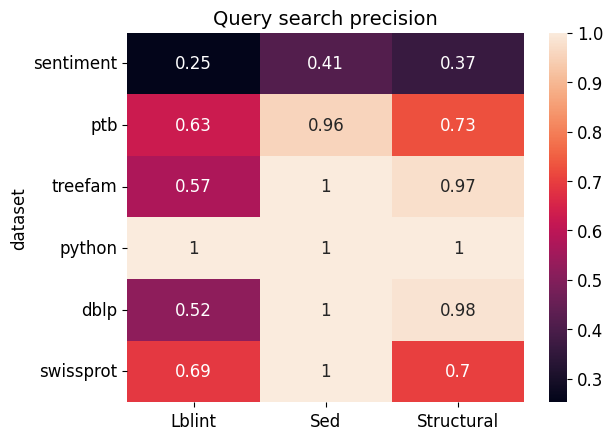

In [195]:
hp = sns.heatmap(data=pdf, annot=True)
hp.set(title='Query search precision')

# TED Search LB filters

Printing  sentiment
Printing  ptb
Printing  treefam
Printing  python
Printing  dblp
Printing  swissprot


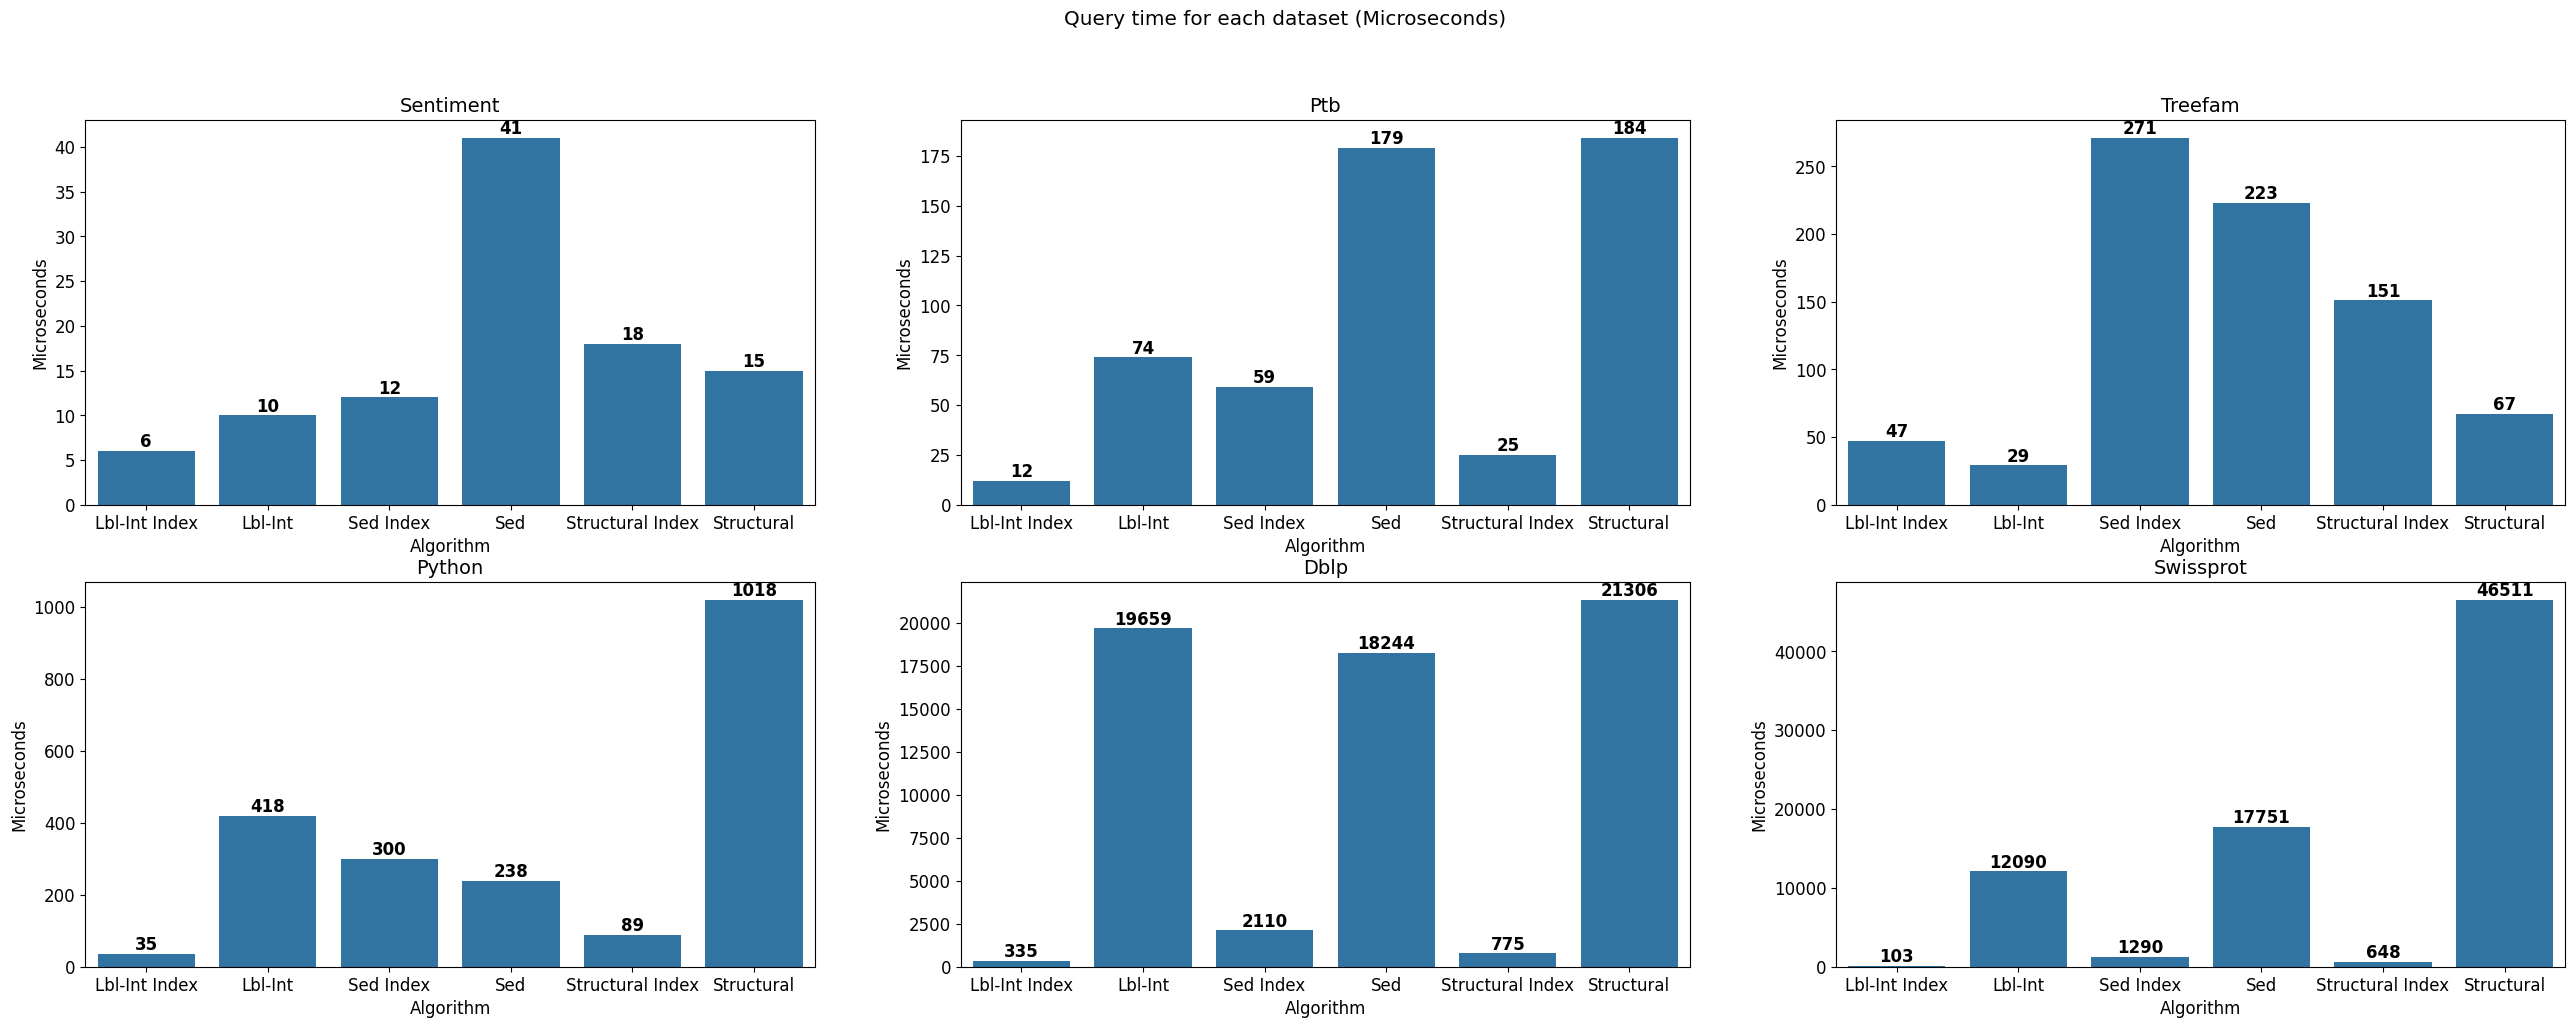

In [196]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
tdf = df.transpose()
f.suptitle('Query time for each dataset (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')


Printing  sentiment
Printing  ptb
Printing  treefam
Printing  python
Printing  dblp
Printing  swissprot


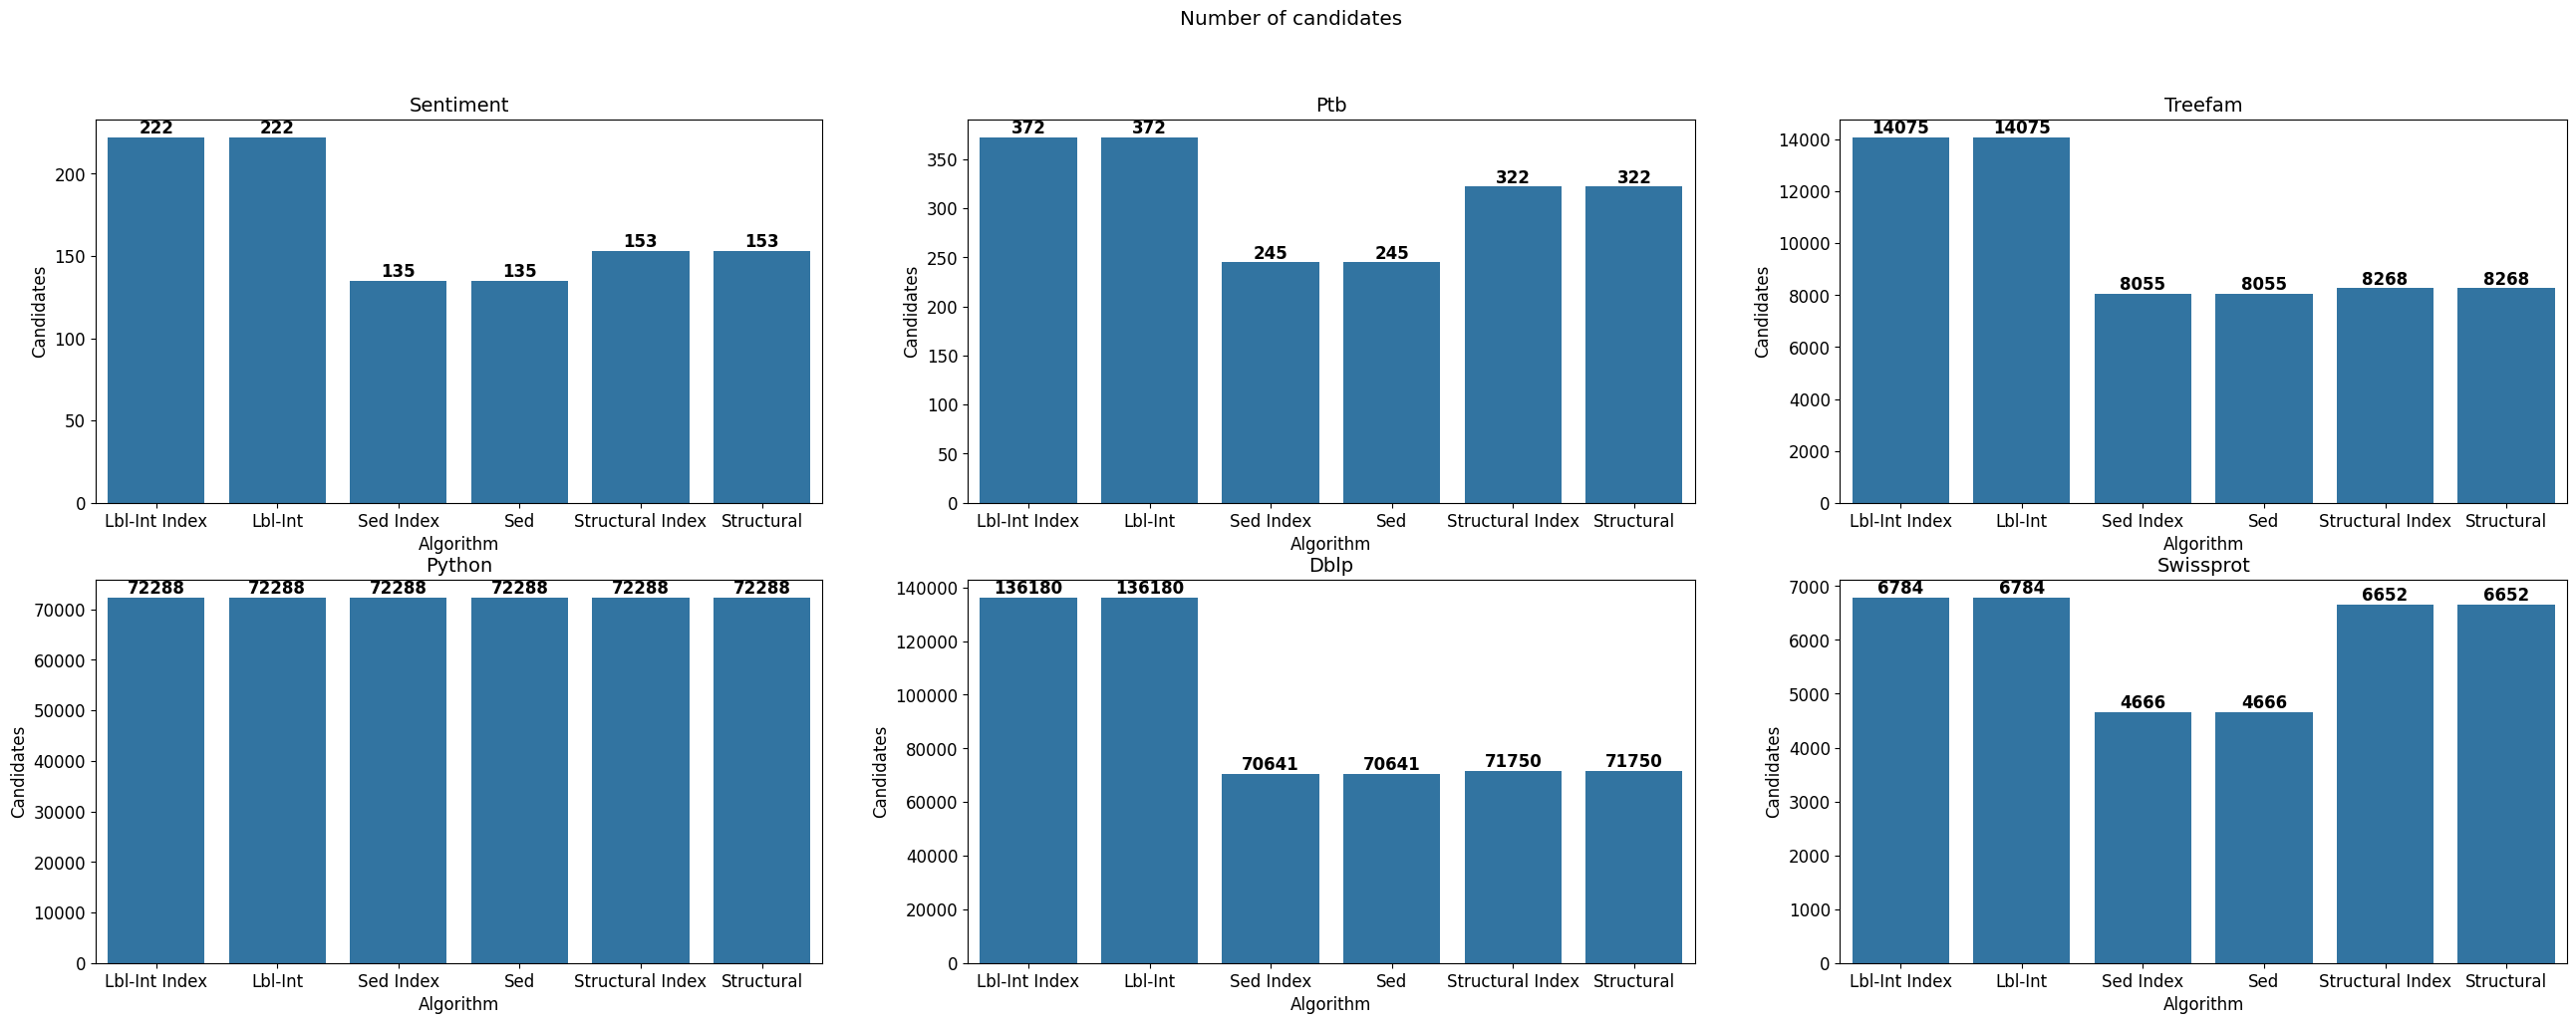

In [197]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
tdf = cdf.transpose()
f.suptitle('Number of candidates')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Candidates')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')

In [198]:
jdf = df.join(cdf, on='dataset', rsuffix='-candidates')

for alg in ALGORITHMS.values():
    if alg not in jdf:
        continue
    
    jdf[f'{alg}-ratio'] = round(jdf[f'{alg}'] / jdf[f'{alg}-candidates'], 4)

display(jdf.iloc[:, 12:])

,Structural-ratio,Sed-ratio,Lbl-Int-ratio,Sed Index-ratio,Lbl-Int Index-ratio,Structural Index-ratio
dataset,,,,,,
sentiment,0.098,0.304,0.045,0.089,2.700e-02,0.118
ptb,0.571,0.731,0.199,0.241,3.230e-02,0.078
treefam,0.008,0.028,0.002,0.034,3.300e-03,0.018
python,0.014,0.003,0.006,0.004,5.000e-04,0.001
dblp,0.297,0.258,0.144,0.030,2.500e-03,0.011
swissprot,6.992,3.804,1.782,0.277,1.520e-02,0.097


Printing  sentiment
Printing  ptb
Printing  treefam
Printing  python
Printing  dblp
Printing  swissprot


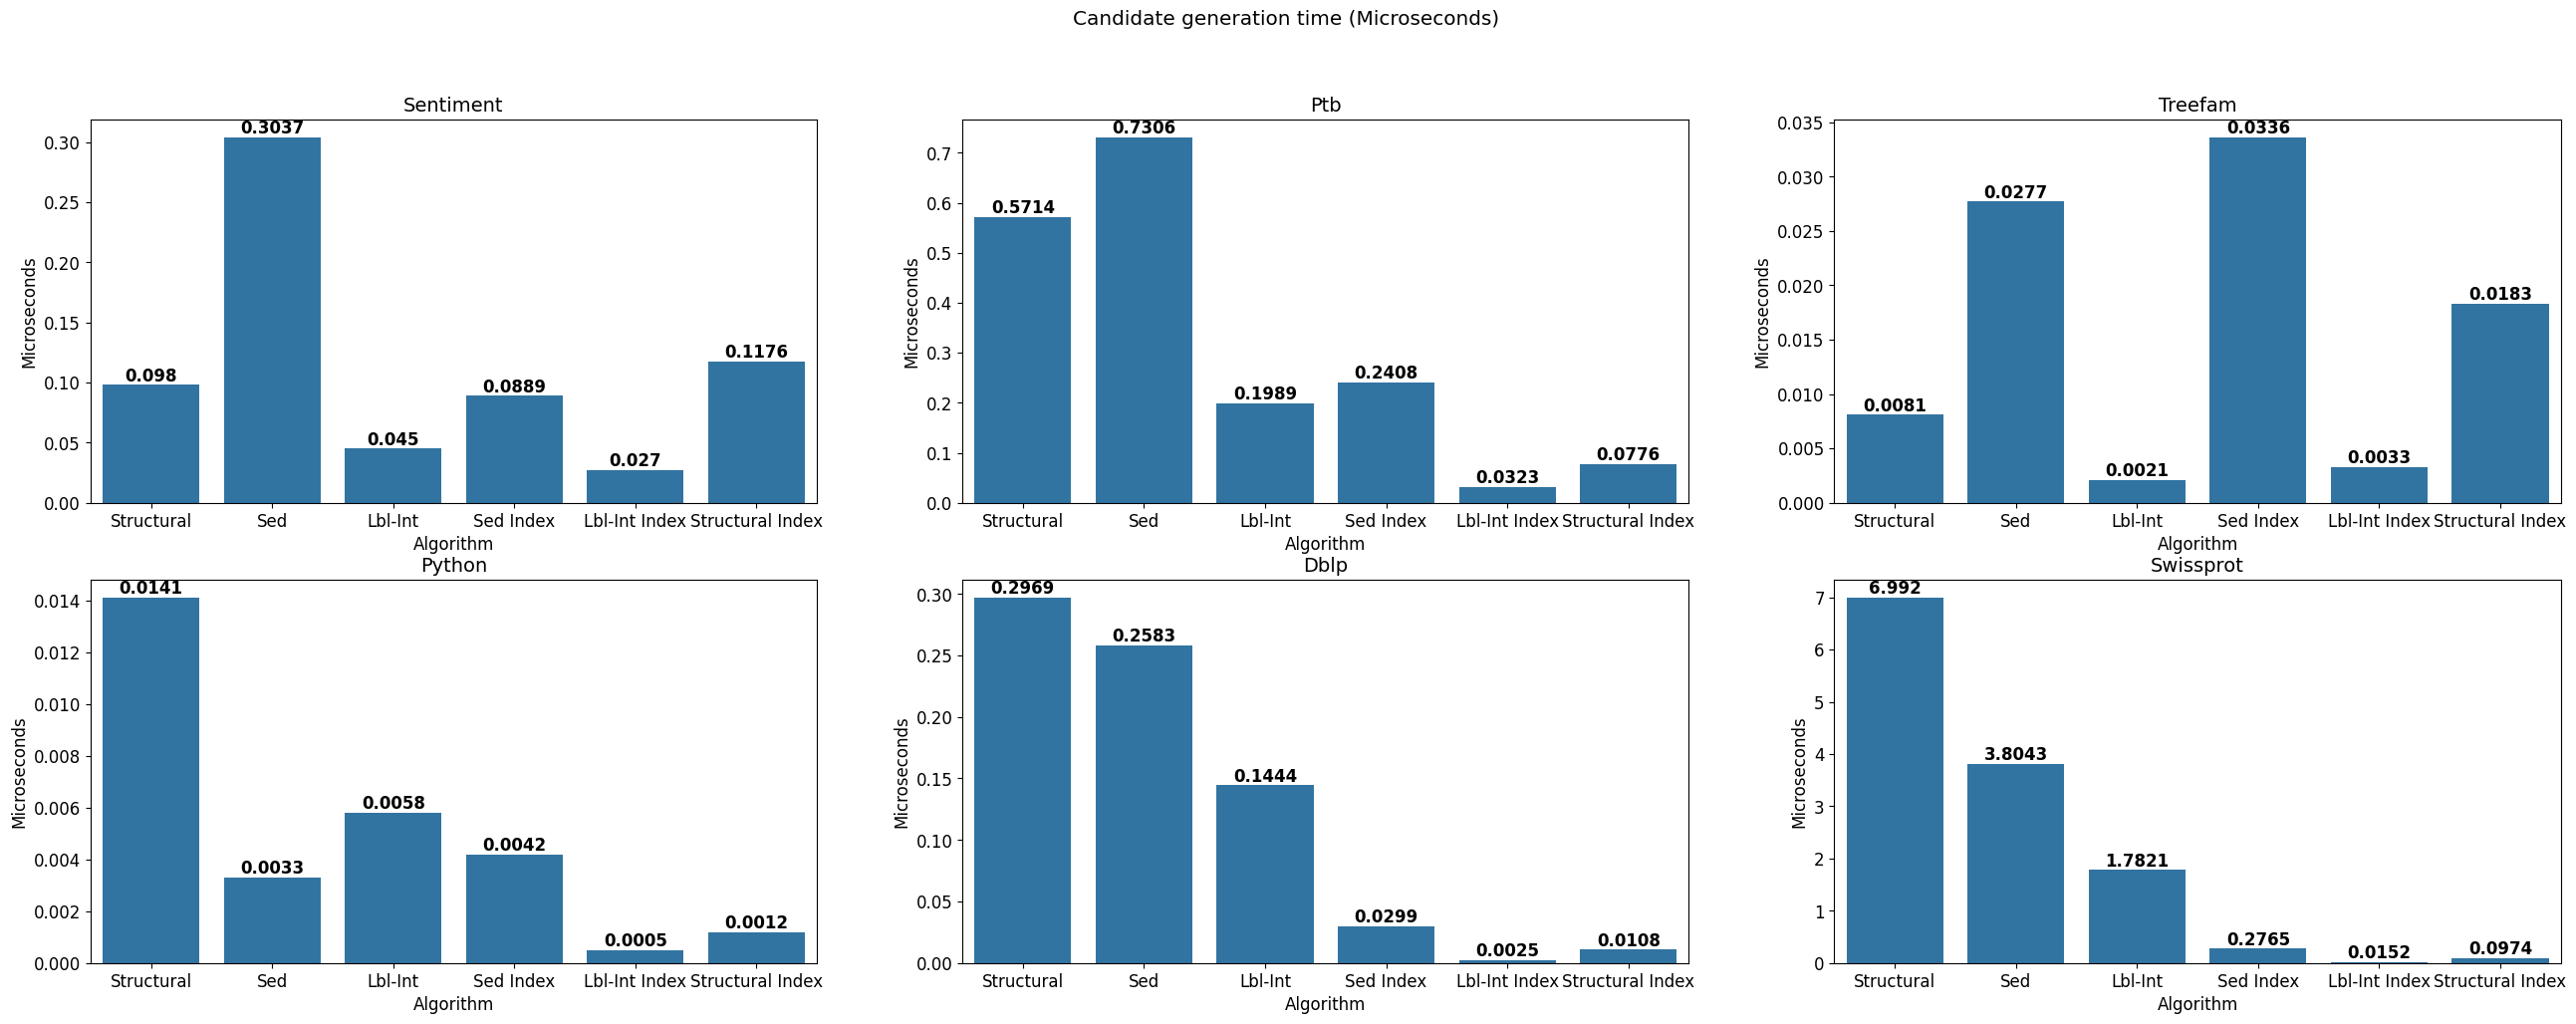

In [199]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
jdf = jdf.iloc[:, 12:].rename(mapper=lambda x: x.replace('-ratio', ''), axis=1)
tdf = jdf.transpose()
f.suptitle('Candidate generation time (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')

In [123]:
tdf['dblp']

Series([], Name: dblp, dtype: float64)

In [202]:
df['Dataset'] = df.index

In [203]:
df['process_part'] = 'searching'

In [204]:
vdf['process_part'] = 'verification'

In [205]:
df

,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural,Dataset,process_part
dataset,,,,,,,,
sentiment,6,10,12,41,18,15,sentiment,searching
ptb,12,74,59,179,25,184,ptb,searching
treefam,47,29,271,223,151,67,treefam,searching
python,35,418,300,238,89,1018,python,searching
dblp,335,19659,2110,18244,775,21306,dblp,searching
swissprot,103,12090,1290,17751,648,46511,swissprot,searching


In [206]:
ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])

In [207]:
complete = pd.concat([ldf, vdf])

In [208]:
complete

,Dataset,process_part,Method,Time
0,sentiment,searching,Lbl-Int Index,6.000
1,ptb,searching,Lbl-Int Index,12.000
2,treefam,searching,Lbl-Int Index,47.000
3,python,searching,Lbl-Int Index,35.000
4,dblp,searching,Lbl-Int Index,335.000
...,...,...,...,...
4,ptb,verification,Structural Index,234.010
4,python,verification,Structural Index,9727.251
4,sentiment,verification,Structural Index,12.227
4,swissprot,verification,Structural Index,84109.027


In [79]:
import seaborn.objects as so

In [209]:
plot_data = complete.pivot_table(
    index=['Dataset', 'Method'],
    columns='process_part',
    values='Time'
).reset_index()

In [210]:
plot_data

process_part,Dataset,Method,searching,verification
0,dblp,Lbl-Int,19659.0,12704.439
1,dblp,Lbl-Int Index,335.0,12704.439
2,dblp,Sed,18244.0,6559.421
3,dblp,Sed Index,2110.0,6559.421
4,dblp,Structural,21306.0,6683.186
5,dblp,Structural Index,775.0,6683.186
6,ptb,Lbl-Int,74.0,259.956
7,ptb,Lbl-Int Index,12.0,259.956
8,ptb,Sed,179.0,211.555
9,ptb,Sed Index,59.0,211.555


In [82]:
from matplotlib.scale import ScaleBase

In [83]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

# Search + Verification time plot for DS

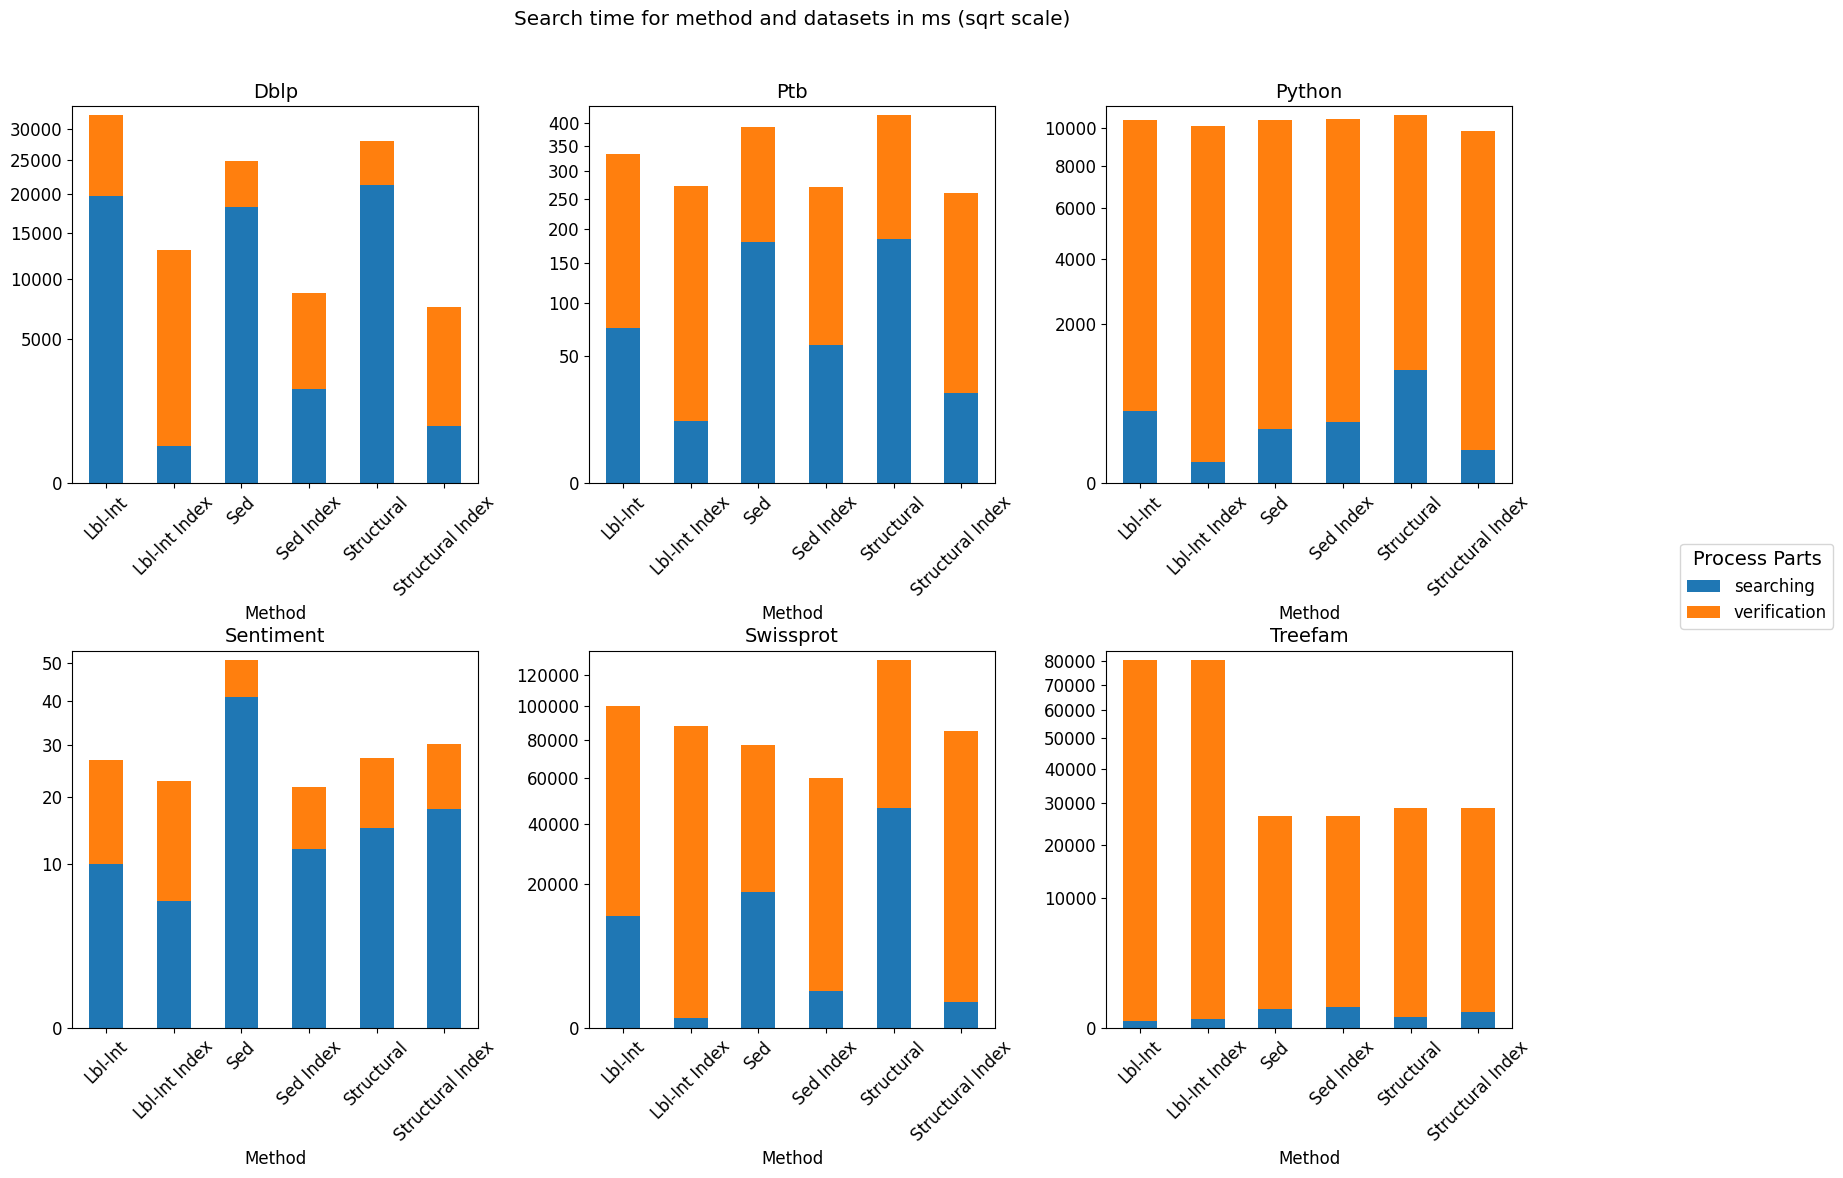

In [84]:
# Create subplot for each dataset
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
# Keep track of legend handles and labels
legend_handles = []
legend_labels = []
for dataset, ax in zip(complete['Dataset'].unique(), axes.ravel()):
    dataset_data = plot_data[plot_data['Dataset'] == dataset].set_index('Method')
    plot = dataset_data.drop('Dataset', axis=1).plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=False,
        title=dataset.capitalize(),
    )
    ax.set_xlabel('Method')
    ax.tick_params(axis='x', rotation=45)
    # Set sqrt scale
    # ax.set_yscale('log')
    ax.set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
    ax.set_ylim(bottom=0)

    # Remove individual legends
    # ax.get_legend().remove()
    if dataset == complete['Dataset'].unique()[0]:
        legend_handles = plot.containers
        legend_labels = dataset_data.drop('Dataset', axis=1).columns

# Add single legend outside plots
fig.legend(
    legend_handles, 
    legend_labels,
    title='Process Parts',
    bbox_to_anchor=(1.05, 0.5),
    loc='center left'
)
# Adjust layout
plt.tight_layout()
plt.suptitle('Search time for method and datasets in ms (sqrt scale)')
# Add extra space for legend
plt.subplots_adjust(top=0.9, right=0.95)


# Show plot
plt.show()

# Dissimilarity

In [9]:
from os.path import join

In [10]:
from io import StringIO

In [11]:
tested_values

[('bolzano', 6),
 ('sentiment', 10),
 ('ptb', 15),
 ('treefam', 60),
 ('python', 15),
 ('dblp', 6)]

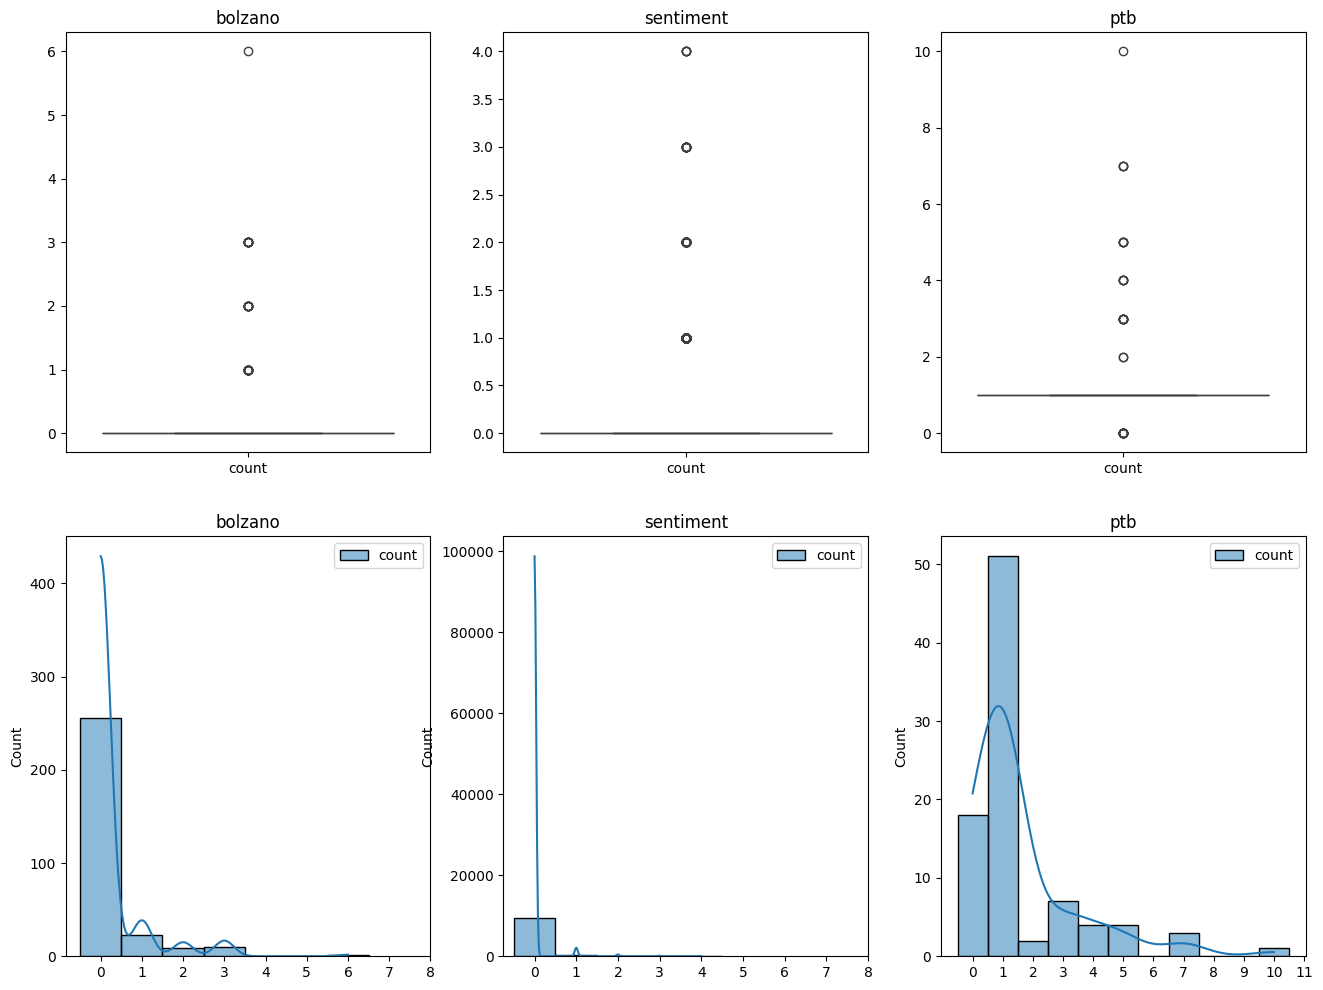

In [12]:
BASEPATH = 'resources/puser-results/'
# tested_values = [('bolzano', 5)]

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

for i, (ds, _) in enumerate(tested_values[:3]):
    cfilename = join(BASEPATH, ds, 'dissimilarity', 'Structural_candidates.csv')
    with open(cfilename) as f:
        lines = f.readlines()
        lines_len = len(lines)
        lines = None
    
    vfilename = join(BASEPATH, ds, 'dissimilarity', 'verified.txt')
    with open(vfilename) as f:
        lines = f.readlines()
        actual = [l.strip() for l in lines[lines_len:]]
    df = pd.read_csv(StringIO('\n'.join(actual)), names=['T1', 'T2'])
    df = df.sort_values(by=['T1', 'T2'])
    # Filter rows where T1 != T2 and count T1
    filtered_counts = df[df['T1'] != df['T2']]['T1'].value_counts()
    # First count all occurrences of T1
    total_counts = df['T1'].value_counts()
    bxdata = filtered_counts.reindex(total_counts.index, fill_value=0).reset_index().sort_values(by=['T1']).set_index('T1')
    bp = sns.boxplot(bxdata, ax=axes[0][i])
    bp.set_title(ds)
    bxdata.head()
    hp = sns.histplot(bxdata, ax=axes[1][i], discrete=True, kde=True)
    hp.set_xticks(range(bxdata['count'].nunique() + 4))
    hp.set_title(ds)
    

In [15]:
tested_values

[('bolzano', 6),
 ('sentiment', 10),
 ('ptb', 15),
 ('treefam', 60),
 ('python', 15),
 ('dblp', 6)]

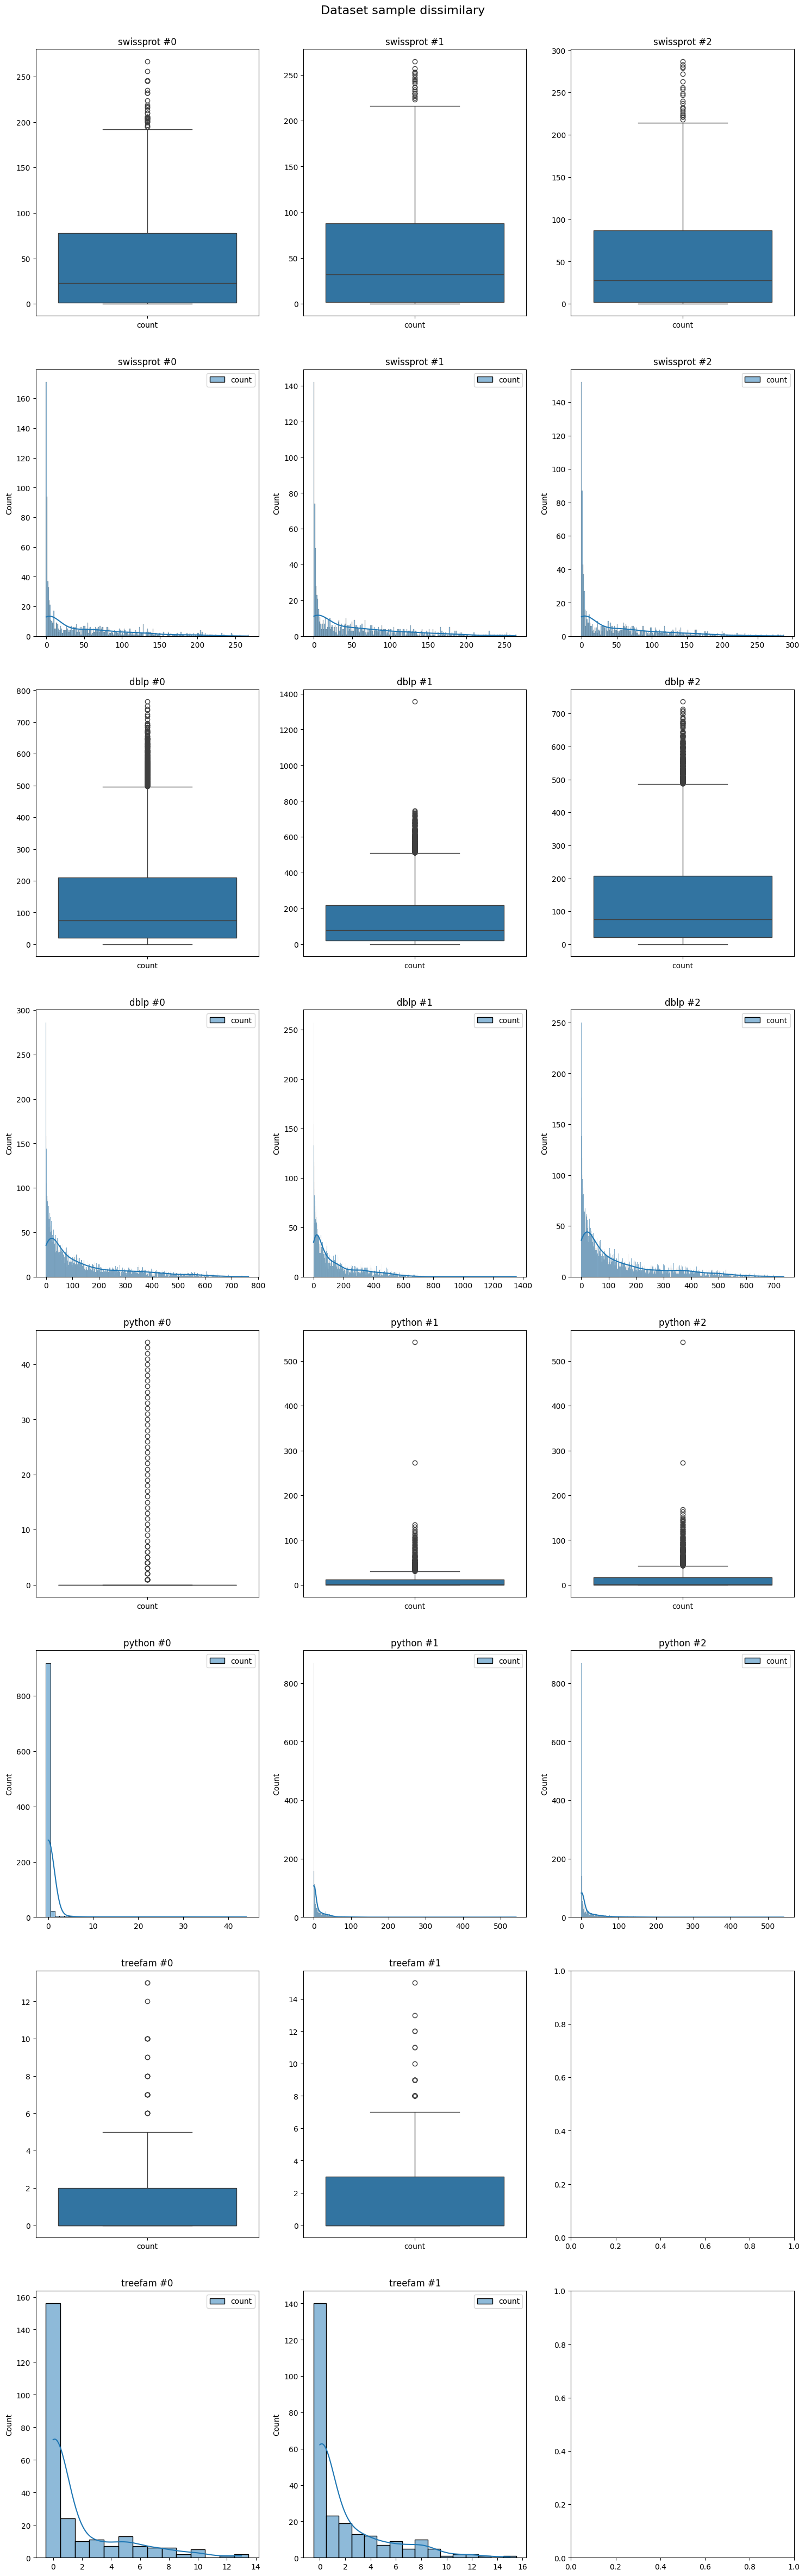

In [29]:
BASEPATH = 'resources/dissimilarity/sample'
# tested_values = [('bolzano', 5)]

fig, axes = plt.subplots(8, 3, figsize=(18, 54))

for i, ds in enumerate(('swissprot', 'dblp', 'python', 'treefam')):
    s = i * 2
    max_results = 2 if ds == 'treefam' else 3
    for j in range(max_results):
        vfilename = join(BASEPATH, ds, str(j), 'verified.txt')
        with open(vfilename) as f:
            actual = [l for l in f if ',' in l]
        df = pd.read_csv(StringIO(''.join(actual)), names=['T1', 'T2'])
        df = df.sort_values(by=['T1', 'T2'])
        # Filter rows where T1 != T2 and count T1
        filtered_counts = df[df['T1'] != df['T2']]['T1'].value_counts()
        # First count all occurrences of T1
        total_counts = df['T1'].value_counts()
        bxdata = filtered_counts.reindex(total_counts.index, fill_value=0).reset_index().sort_values(by=['T1']).set_index('T1')
        bp = sns.boxplot(bxdata, ax=axes[s][j])
        bp.set_title(ds + f' #{j}')
        bxdata.head()
        hp = sns.histplot(bxdata, ax=axes[s + 1][j], discrete=True, kde=True)
        # hp.set_xticks(range(bxdata['count'].nunique() + 4))
        hp.set_title(ds + f' #{j}')
fig.suptitle('Dataset sample dissimilary', fontsize=16)
fig.subplots_adjust(top=0.965)

# Generated dissimilarity

In [211]:
ALGORITHMS

{'structural': 'Structural',
 'structural-variant': 'Splitted Structural',
 'sed': 'Sed',
 'lblint': 'Lbl-Int',
 'bib': 'Binary branch',
 'sedindex': 'Sed Index',
 'lblindex': 'Lbl-Int Index',
 'structuralindex': 'Structural Index'}

In [212]:
from os.path import join

bases = [f'base-{b}' for b in [25,50,100,200]]
datasets = [f'{base}/{x}' for x in ['lsmall', 'lmedium', 'lbig'] for base in bases]
df = pd.DataFrame()
for ds in datasets:
    tdf = get_query_runtime_for_df('resources/workloads/generated', ds)
    df = pd.concat([df, tdf])
            
df = df.rename(columns={
    'Lblint index': ALGORITHMS['lblindex'],
    'Lblint': ALGORITHMS['lblint'],
    'Sed Index': ALGORITHMS['sedindex'],
    'Sed': ALGORITHMS['sed'],
    'Structural Index': ALGORITHMS['structuralindex'],
    'Structural': ALGORITHMS['structural'],
    })
df = df.set_index('Dataset')
df['process_part'] = 'searching'
display(df)
# df = pd.DataFrame()
# cdf = pd.DataFrame()
# for ds in datasets:
#     times_path = join('resources/puser-results', ds, 'times.txt')
#     t = pd.read_csv(times_path, delimiter=';')
#     t = t.rename(columns=ALGORITHMS)
#     df = pd.concat([df, t.head(1)])
    
#     cdf = pd.concat([cdf, t.iloc[[1]]])
# df = df.set_index('dataset')
# cdf = cdf.set_index('dataset')
# # display(df)
# display(df.transpose())
# display(cdf)

,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural,process_part
Dataset,,,,,,,
base-25/lsmall,138,436,3586,3554,15,557,searching
base-50/lsmall,182,429,3617,3606,15,598,searching
base-100/lsmall,213,459,3622,3612,17,668,searching
base-200/lsmall,241,461,3566,3578,18,659,searching
base-25/lmedium,38,441,3703,3669,9,454,searching
base-50/lmedium,27,386,3606,3605,6,452,searching
base-100/lmedium,27,407,3612,3622,5,479,searching
base-200/lmedium,50,417,3576,3573,5,476,searching
base-25/lbig,23,350,3609,3622,10,438,searching


In [213]:
pdf = pd.DataFrame()
vdf = pd.DataFrame()
for ds in datasets:
    temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
    tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
    times_ = []
    methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
    for mtd in ('Lblint', 'Sed', 'Structural'):
        k = mtd.replace('Lblint', 'Lbl-Int')
        verification_path = join('resources/workloads/generated', ds, f'{mtd.lower()}-verified.txt')
        with open(verification_path) as f:
            lines = f.read().split('\n')
        times = pd.Series([float(t) for t in lines if ',' not in t and t])
        correct_results = [l for l in lines if ',' in l and l]
        # candidate_count = 
        # precision =  (len(lines) - 1 - candidate_count) / candidate_count
        # temp_df[mtd] = precision
        temp_df

        total_verification_time_ms = times.div(1000_000).sum()
        # twice for index version
        times_.extend([total_verification_time_ms, total_verification_time_ms])
        # print(ds, mtd, precision)
    # temp_df = pd.DataFrame()
    # pdf = pd.concat([pdf, temp_df])
    vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])

# pdf = pdf.set_index("dataset")
vdf.sort_values(['Method', 'Dataset'], inplace=True)
# display(pdf)
display(vdf)


,Dataset,process_part,Method,Time
1,base-100/lbig,verification,Lbl-Int,19587.659
1,base-100/lmedium,verification,Lbl-Int,18953.855
1,base-100/lsmall,verification,Lbl-Int,19757.015
1,base-200/lbig,verification,Lbl-Int,8872.244
1,base-200/lmedium,verification,Lbl-Int,8893.315
...,...,...,...,...
4,base-25/lmedium,verification,Structural Index,131048.606
4,base-25/lsmall,verification,Structural Index,79513.881
4,base-50/lbig,verification,Structural Index,38270.105
4,base-50/lmedium,verification,Structural Index,39506.047


In [215]:
df['Dataset'] = df.index
df

,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural,process_part,Dataset
Dataset,,,,,,,,
base-25/lsmall,138,436,3586,3554,15,557,searching,base-25/lsmall
base-50/lsmall,182,429,3617,3606,15,598,searching,base-50/lsmall
base-100/lsmall,213,459,3622,3612,17,668,searching,base-100/lsmall
base-200/lsmall,241,461,3566,3578,18,659,searching,base-200/lsmall
base-25/lmedium,38,441,3703,3669,9,454,searching,base-25/lmedium
base-50/lmedium,27,386,3606,3605,6,452,searching,base-50/lmedium
base-100/lmedium,27,407,3612,3622,5,479,searching,base-100/lmedium
base-200/lmedium,50,417,3576,3573,5,476,searching,base-200/lmedium
base-25/lbig,23,350,3609,3622,10,438,searching,base-25/lbig


In [216]:
ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])

In [218]:
complete = pd.concat([ldf, vdf])
complete

,Dataset,process_part,Method,Time
0,base-25/lsmall,searching,Lbl-Int Index,138.000
1,base-50/lsmall,searching,Lbl-Int Index,182.000
2,base-100/lsmall,searching,Lbl-Int Index,213.000
3,base-200/lsmall,searching,Lbl-Int Index,241.000
4,base-25/lmedium,searching,Lbl-Int Index,38.000
...,...,...,...,...
4,base-25/lmedium,verification,Structural Index,131048.606
4,base-25/lsmall,verification,Structural Index,79513.881
4,base-50/lbig,verification,Structural Index,38270.105
4,base-50/lmedium,verification,Structural Index,39506.047


In [219]:
plot_data = complete.pivot_table(
    index=['Dataset', 'Method'],
    columns='process_part',
    values='Time'
).reset_index()

In [184]:
plot_data

process_part,Dataset,Method,searching,verification
0,base-100/lbig,Lbl-Int,374.0,19587.659
1,base-100/lbig,Lbl-Int Index,14.0,19587.659
2,base-100/lbig,Sed,3576.0,16387.631
3,base-100/lbig,Sed Index,3596.0,16387.631
4,base-100/lbig,Structural,441.0,18165.151
...,...,...,...,...
67,base-50/lsmall,Lbl-Int Index,182.0,42911.857
68,base-50/lsmall,Sed,3606.0,102826.839
69,base-50/lsmall,Sed Index,3617.0,102826.839
70,base-50/lsmall,Structural,598.0,38430.418


In [222]:
BASEPATH = 'resources/workloads/generated/base-25'

In [223]:
from os.path import join
def get_query_runtime_for_df(basepath: str, ds: str):
    qt = join(basepath, ds, 'query_times.txt')
    # qt = f'resources/workloads/generated/{ds}/query_times.txt'
    with open(qt) as f:
        content = f.read()
    times = [l.split(':')[1].strip('ms') for i, l in enumerate(content.split('\n')) if i % 3 == 1]
    candidates = [l.split(':')[1] for i, l in enumerate(content.split('\n')) if i % 3 == 2]
    methods = [l for i, l in enumerate(content.split('\n')) if i % 3 == 0 and l]
    csv_content = ','.join(methods) + '\n' +','.join(times)  + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds])
    # df = df.set_index('Dataset')
    return df

In [238]:
from os.path import dirname, basename, join
def print_generated_dissimilar(basepath: str, title = ''):
    fig, axes = plt.subplots(3, 3, figsize=(14, 16))
    stats_df = pd.DataFrame()
    
    for i, ds in enumerate(('lsmall', 'lmedium', 'lbig')):
        
        
        vfilename = join(basepath, ds, 'verified.txt')
        df = pd.read_csv(join(basepath, ds, 'collection.csv'))
        df.insert(0, 'Dataset', [ds.capitalize()])
        stats_df = pd.concat([stats_df, df])
        with open(vfilename) as f:
            actual = [l for l in f if ',' in l]
        df = pd.read_csv(StringIO(''.join(actual)), names=['T1', 'T2'])
        df = df.sort_values(by=['T1', 'T2'])
        # Filter rows where T1 != T2 and count T1
        filtered_counts = df[df['T1'] != df['T2']]['T1'].value_counts()
        # First count all occurrences of T1
        total_counts = df['T1'].value_counts()
        bxdata = filtered_counts.reindex(total_counts.index, fill_value=0).reset_index().sort_values(by=['T1']).set_index('T1')
        bp = sns.boxplot(bxdata, ax=axes[0][i])
        bp.set_title(f'{ds.capitalize()} # similar trees')
        bxdata.head()
        hp = sns.histplot(bxdata, ax=axes[1][i], discrete=True, kde=True)
        # hp.set_xticks(range(bxdata['count'].nunique() + 4))
        hp.set_title(f'{ds.capitalize()} # similar trees')
        # used for total query time
        plot_ds_name = join(basename(basepath), ds)
        dataset_data = plot_data[plot_data['Dataset'] == plot_ds_name].set_index('Method')
        ax = axes[2][i]
        plot = dataset_data.drop('Dataset', axis=1).plot(
            kind='bar',
            stacked=True,
            ax=ax,
            legend=False,
            title=ds.capitalize(),
        )
        ax.set_xlabel('Method')
        ax.tick_params(axis='x', rotation=45)
        # Set sqrt scale
        # ax.set_yscale('log')
        ax.set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
        ax.set_ylim(bottom=0)
    
        # qdf = get_query_runtime_for_df(basepath, ds)
        # bx = sns.barplot(qdf, ax=axes[2][i])
        # bx.set_title(f'{ds.capitalize()} query times (ms)')
        # axes[2][i].set_yscale('log')
        # # axes[2][i].set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
        # bx.tick_params('x', rotation=45)
        # for ix in bx.containers:
        #     bx.bar_label(ix, padding=2)
    
    fig.suptitle('Generated dataset dissimilary ' + title, fontsize=16)
    stats_df = stats_df.rename(columns={
        'min_tree': 'Min tree size',
        'max_tree': 'Max tree size',
        'avg_tree': 'Average tree size',
        'tree_count': 'Trees',
        'avg_unique_labels_per_tree': 'Avg. unique labels for a tree',
        'avg_tree_distinct_labels': 'Avg. distinct labels in tree',
        'distinct_labels': 'No. of distinct labels',
        'trees': 'No. of trees in dataset',
    })
    plt.tight_layout()
    
    display(stats_df)
    # fig.subplots_adjust(top=0.965)

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels,Unnamed: 7
0,Lsmall,91,117,103.334,1000,0.078,101.907,2989,NaN
0,Lmedium,92,118,104.396,1000,4.669,104.132,9675,NaN
0,Lbig,89,119,103.500,1000,9.639,103.416,13339,NaN


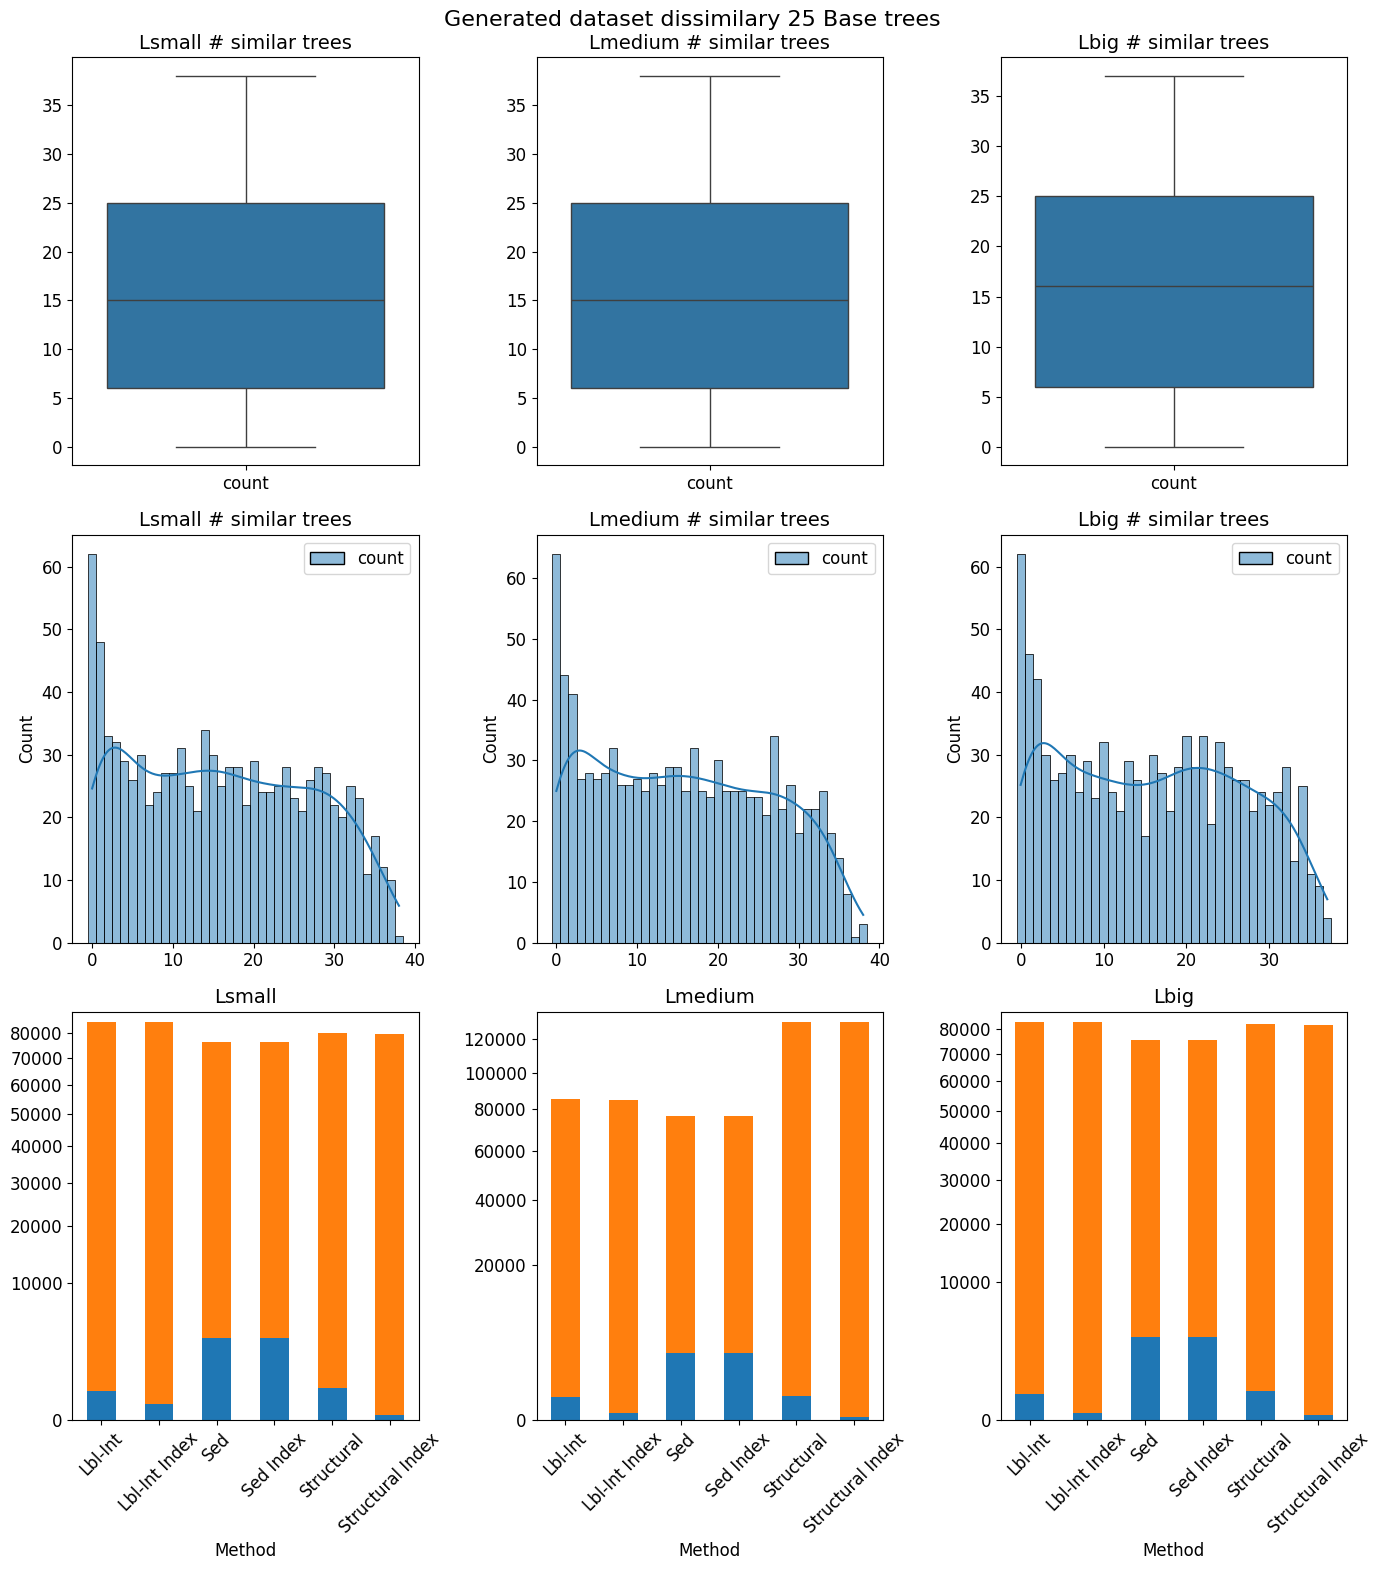

In [239]:
print_generated_dissimilar('resources/workloads/generated/base-25', '25 Base trees')

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels,Unnamed: 7
0,Lsmall,91,117,103.021,1000,0.026,101.218,2994,NaN
0,Lmedium,90,117,103.691,1000,3.985,103.292,10416,NaN
0,Lbig,90,121,103.231,1000,8.947,103.142,14854,NaN


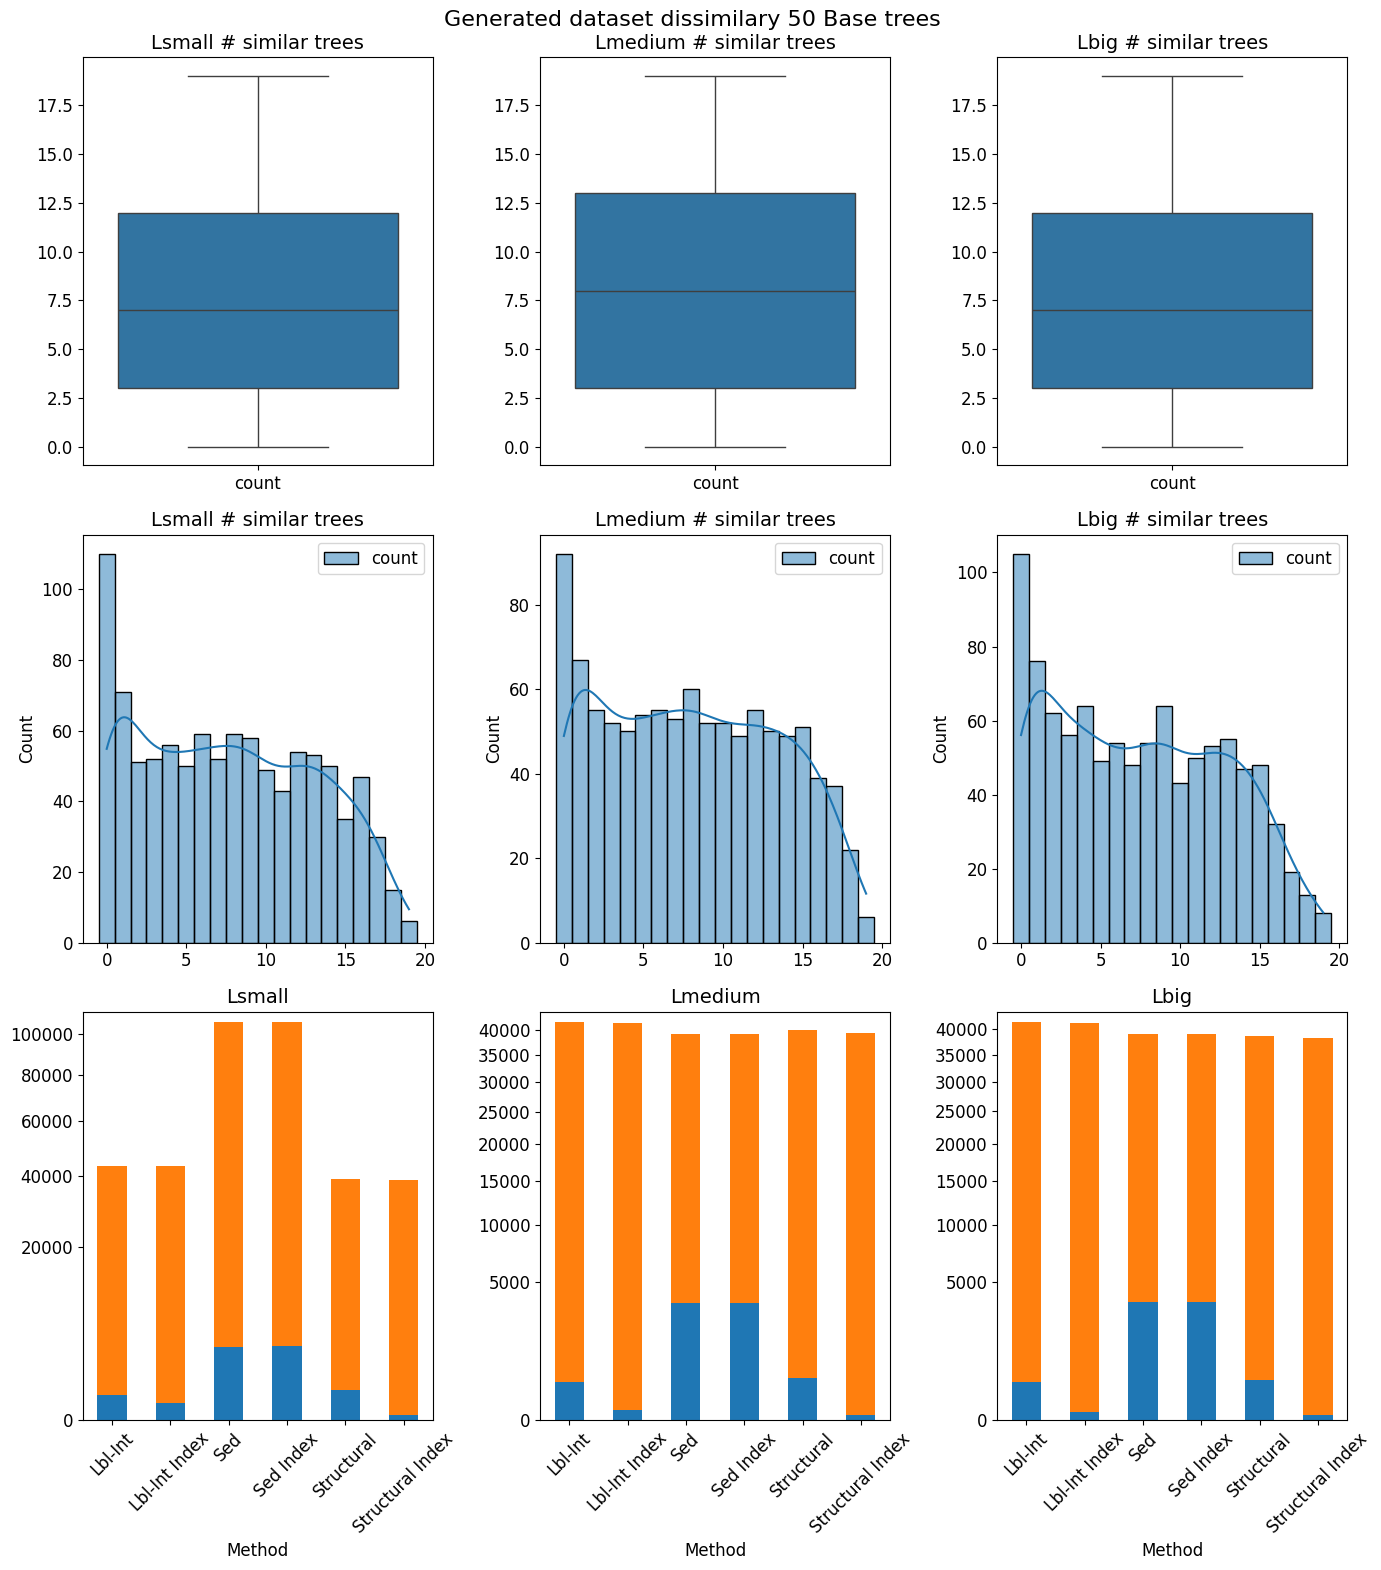

In [240]:
print_generated_dissimilar('resources/workloads/generated/base-50', '50 Base trees')

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels,Unnamed: 7
0,Lsmall,91,116,103.312,1000,0.012,101.547,3001,NaN
0,Lmedium,91,118,103.319,1000,2.861,102.980,11572,NaN
0,Lbig,90,116,102.635,1000,7.886,102.499,17811,NaN


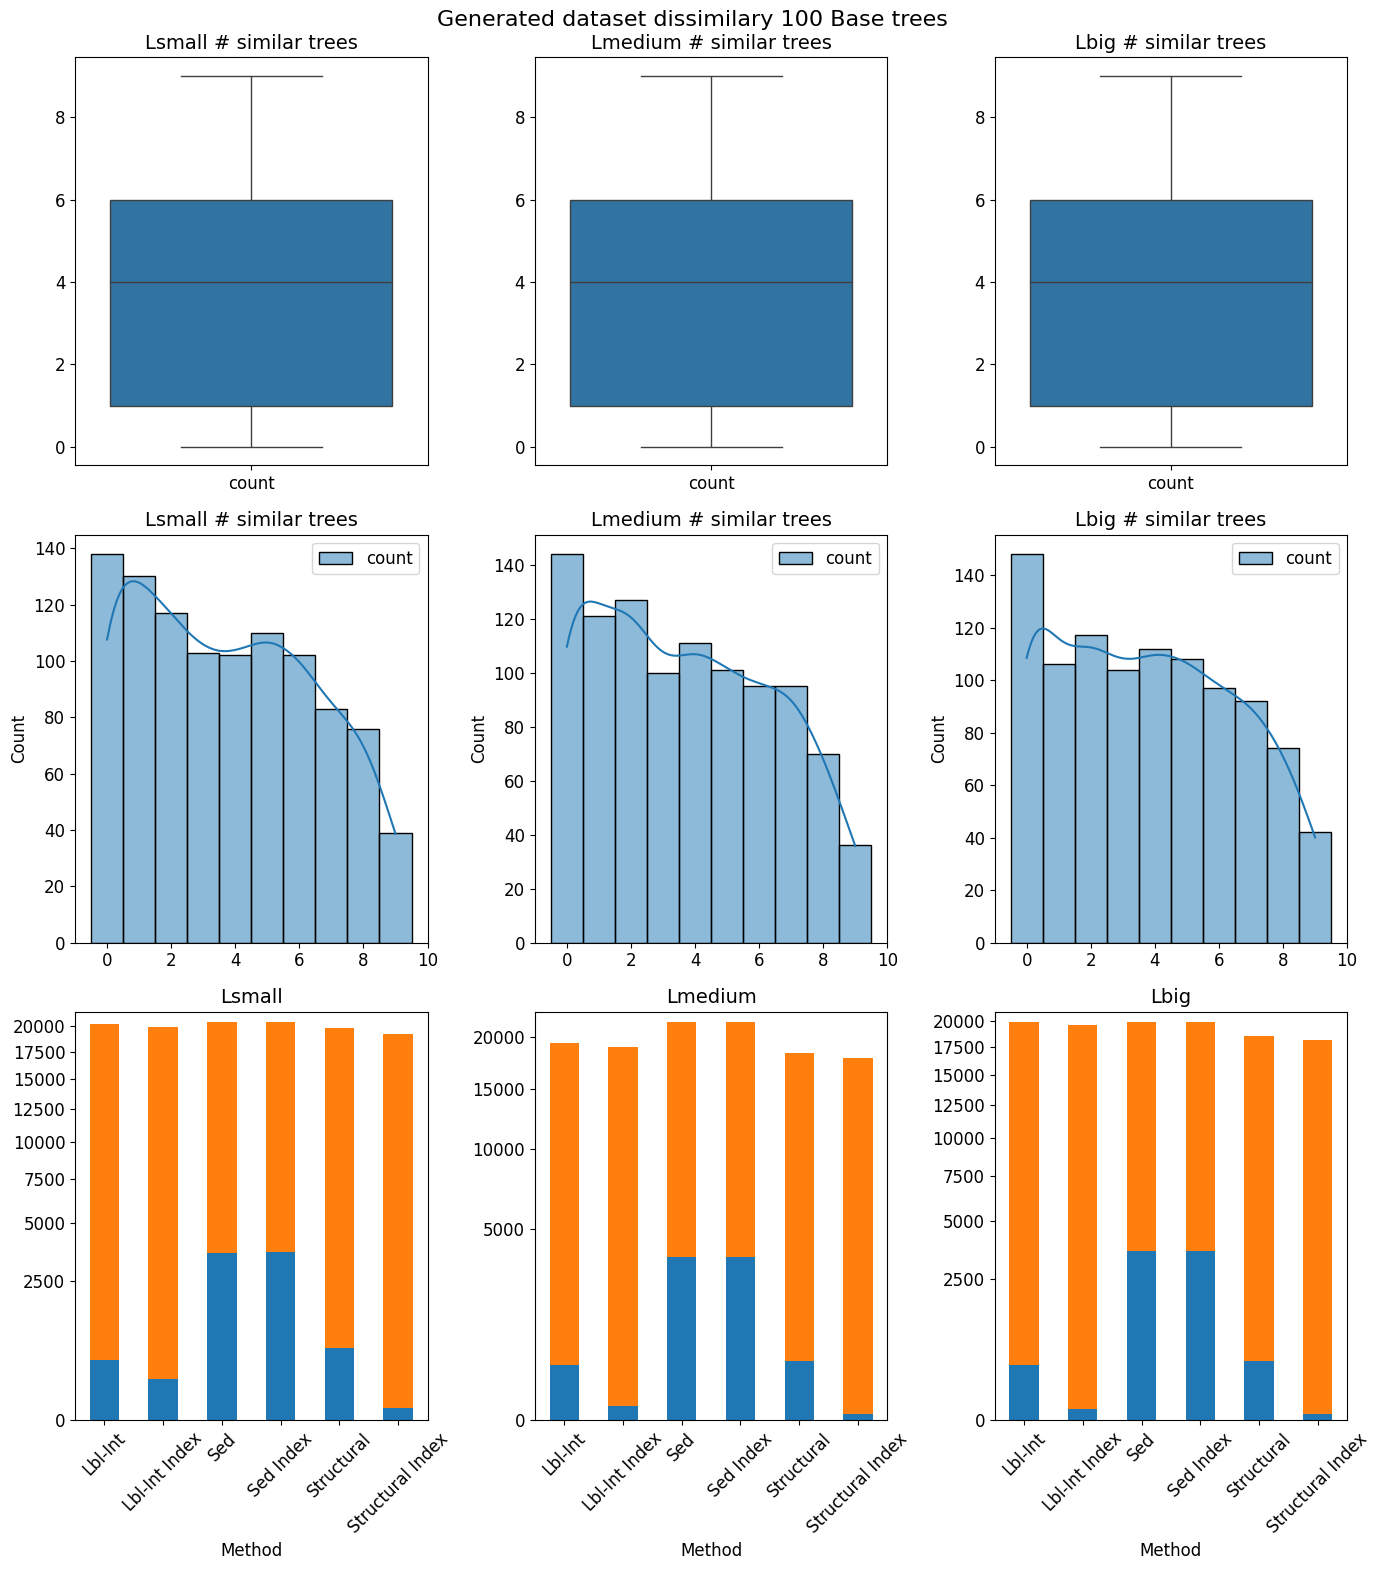

In [241]:
print_generated_dissimilar('resources/workloads/generated/base-100', '100 Base trees')

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels,Unnamed: 7
0,Lsmall,89,115,102.787,1000,0.000,101.219,3001,NaN
0,Lmedium,89,116,102.853,1000,1.423,102.473,13022,NaN
0,Lbig,89,119,103.152,1000,5.767,103.043,22898,NaN


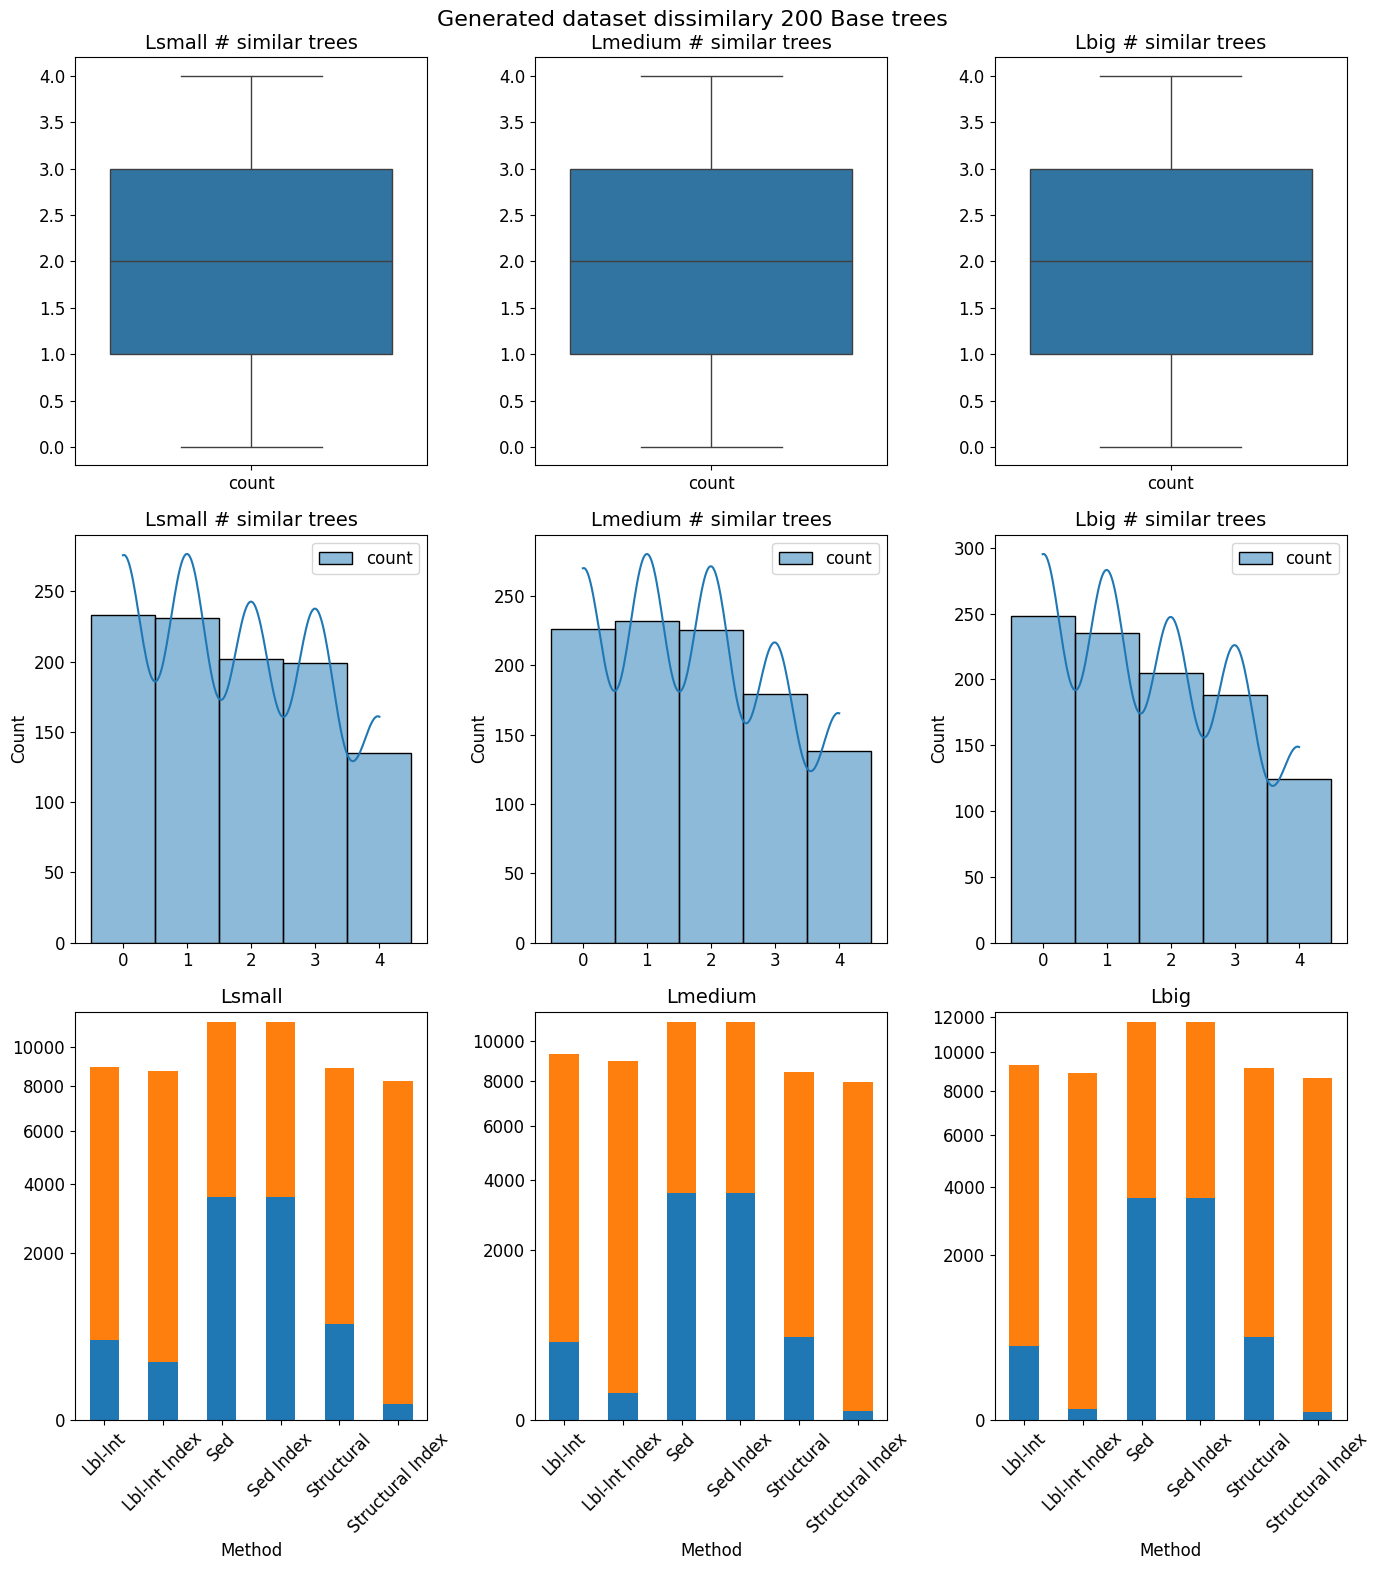

In [242]:
print_generated_dissimilar('resources/workloads/generated/base-200', '200 Base trees')

In [115]:
BASEPATH

'resources/workloads/generated'

In [103]:
qdf = get_query_runtime_for_df(BASEPATH, 'lsmall')

In [43]:
df.transpose()

Dataset,lsmall
Lblint index,182
Lblint,605
Sed Index,4709
Sed,4708
Structural Index,40
Structural,993


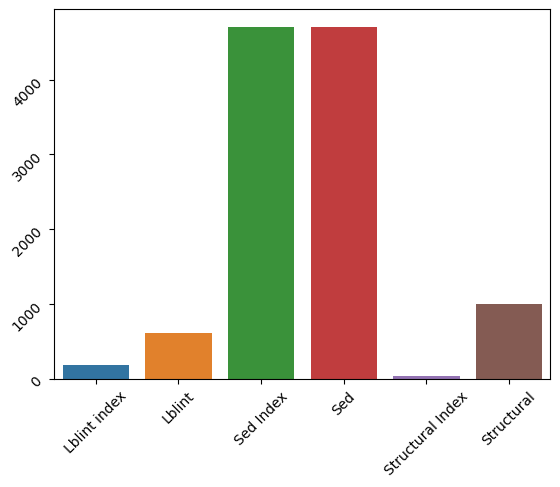

In [47]:
bx = sns.barplot(df)
bx.tick_params(rotation=45)

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
tdf = df.transpose()
f.suptitle('Query time for each dataset (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')


In [44]:
df = pd.DataFrame()
cdf = pd.DataFrame()
for ds in datasets:
    times_path = join('resources/puser-results', ds, 'times.txt')
    t = pd.read_csv(times_path, delimiter=';')
    t = t.rename(columns=ALGORITHMS)
    df = pd.concat([df, t.head(1)])
    
    cdf = pd.concat([cdf, t.iloc[[1]]])
df = df.set_index('dataset')
cdf = cdf.set_index('dataset')
# display(df)
display(df.transpose())
display(cdf)

,count
T1,
0,3
1,3
2,3
3,0
4,3
...,...
294,0
295,0
296,0


<Axes: >

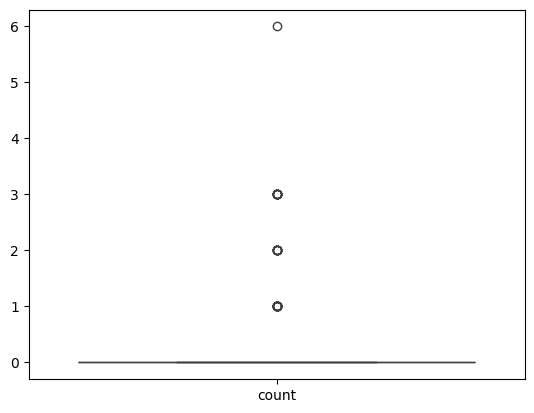

In [63]:
sns.boxplot(bxdata)

<Axes: ylabel='Count'>

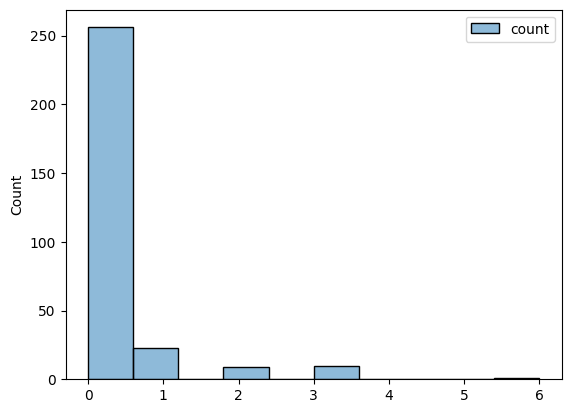

In [64]:
sns.histplot(bxdata)